### Causal ML Analysis: Income-Based Incentives in Residential Retrofit Energy Efficiency Projects

In [1]:
import sys
print(sys.executable)


c:\Users\melam\anaconda3\envs\causalml-env\python.exe


In [2]:
import sys

assert sys.version_info >= (3, 7)

In [3]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [4]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.ensemble import IsolationForest, RandomForestRegressor
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

In [5]:
# For causal inference
import time
import warnings

# Machine learning models and utilities
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

# CausalML meta-learners (S-learner and X-learner)
from causalml.inference.meta import BaseSRegressor, BaseXRegressor

# For SHAP values (model interpretability)
import shap

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

In [6]:
from pathlib import Path
import tarfile
import urllib.request

def load_csv(file_path):
    csv_path = Path(file_path)
    if not csv_path.is_file():
        print("File not found!")
        return None
    return pd.read_csv(csv_path)

file_path = r"C:\MMA\Winter 2025\INSY 695 - Production\Assignment 1\Residential_Existing_Homes__One_to_Four_Units.csv"
df = load_csv(file_path)

## Loading and Exploring the data

In [7]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df.head()

,Reporting Period,Home Performance Project ID,Home Performance Site ID,Project County,Project City,Project Zip,Gas Utility,Electric Utility,Project Completion Date,Customer Type,Low-Rise or Home Performance Indicator,Total Project Cost,Total Incentives,Type of Program Financing,Amount Financed Through Program,Pre-Retrofit Home Heating Fuel Type,Year Home Built,Size of Home,Volume of Home,Number of Units,Measure Type,Estimated Annual kWh Savings,Estimated Annual MMBtu Savings,First Year Energy Savings $ Estimate,Homeowner Received Green Jobs-Green NY Free/Reduced Cost Audit (Y/N),New Georeferenced Column
0,06/30/2023,568997,414238,Erie,Eden,14057,NaN,National Grid,02/22/2023,Assisted,Home Performance,5986,2993,NaN,0,NaN,1957,"2,200","17,600",1.0,Building Shell,106,16,495,Y,POINT (-78.89672 42.652845)
1,06/30/2023,558860,395723,Oswego,Fulton,13069,National Grid,National Grid,12/09/2022,Assisted,Home Performance,9780,4090,NaN,0,Natural Gas,1912,"1,024","8,192",1.0,Building Shell,349,19,256,Y,POINT (-76.41174 43.325035)
2,06/30/2023,551162,397589,Jefferson,Watertown,13601,NaN,National Grid,11/28/2022,Assisted,Home Performance,7468,3734,NaN,0,NaN,1965,"1,500","12,000",1.0,Building Shell,2700,0,340,Y,POINT (-75.9049969 43.9757948)
3,06/30/2023,541719,394286,Tioga,Owego,13827,NaN,New York State Electric & Gas,07/13/2022,Assisted,Home Performance,9590,4795,NaN,0,NaN,1976,"1,850","14,800",1.0,Building Shell,0,14,394,Y,POINT (-76.26612 42.105545)
4,06/30/2023,544732,379592,Oneida,Utica,13502,NaN,National Grid,07/11/2022,Assisted,Home Performance,10000,5000,NaN,0,NaN,1925,"1,568","12,544",1.0,Building Shell,0,35,380,Y,POINT (-75.2472726 43.1010822)


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71381 entries, 0 to 71380
Data columns (total 26 columns):
 #   Column                                                                Non-Null Count  Dtype  
---  ------                                                                --------------  -----  
 0   Reporting Period                                                      71381 non-null  object 
 1   Home Performance Project ID                                           71381 non-null  object 
 2   Home Performance Site ID                                              71381 non-null  object 
 3   Project County                                                        71381 non-null  object 
 4   Project City                                                          71381 non-null  object 
 5   Project Zip                                                           71381 non-null  int64  
 6   Gas Utility                                                           52835 non-null  object 


In [9]:
missing_values = df.isnull().sum()
print(missing_values)

Reporting Period                                                            0
Home Performance Project ID                                                 0
Home Performance Site ID                                                    0
Project County                                                              0
Project City                                                                0
Project Zip                                                                 0
Gas Utility                                                             18546
Electric Utility                                                            0
Project Completion Date                                                     0
Customer Type                                                              69
Low-Rise or Home Performance Indicator                                      0
Total Project Cost                                                          0
Total Incentives                                                

In [10]:
# Convert "Year Home Built" to numeric, forcing errors to NaN
df["Year Home Built"] = pd.to_numeric(df["Year Home Built"], errors='coerce')

# Calculate "Age of Home"
current_year = pd.Timestamp.now().year
df["Age of Home"] = 2023 - df["Year Home Built"]

# Display the first few rows to verify the new column
df[["Year Home Built", "Age of Home"]].head()

df=df.drop(columns=['Year Home Built'])

As mentioned under data dictionary, rows missing 'Age of Home', 'Number of Units', 'Size of Home' and 'Volume of Home' were systematically tied to projects completed before January 1, 2018, due to data collection policies in place at the time. These projects represent a distinct subset with limited feature availability. To maintain consistency and focus on projects with complete information, these rows were excluded from the dataset.

Dropping rows with missing values under 'Customer Type' as the number of missing values are insignificant and the accurate input is critical in the causal inference stage.

In [11]:
df = df.dropna(subset=['Age of Home', 'Number of Units', 'Customer Type'])

In [12]:
missing_values = df.isnull().sum()
print(missing_values)

Reporting Period                                                            0
Home Performance Project ID                                                 0
Home Performance Site ID                                                    0
Project County                                                              0
Project City                                                                0
Project Zip                                                                 0
Gas Utility                                                             10745
Electric Utility                                                            0
Project Completion Date                                                     0
Customer Type                                                               0
Low-Rise or Home Performance Indicator                                      0
Total Project Cost                                                          0
Total Incentives                                                

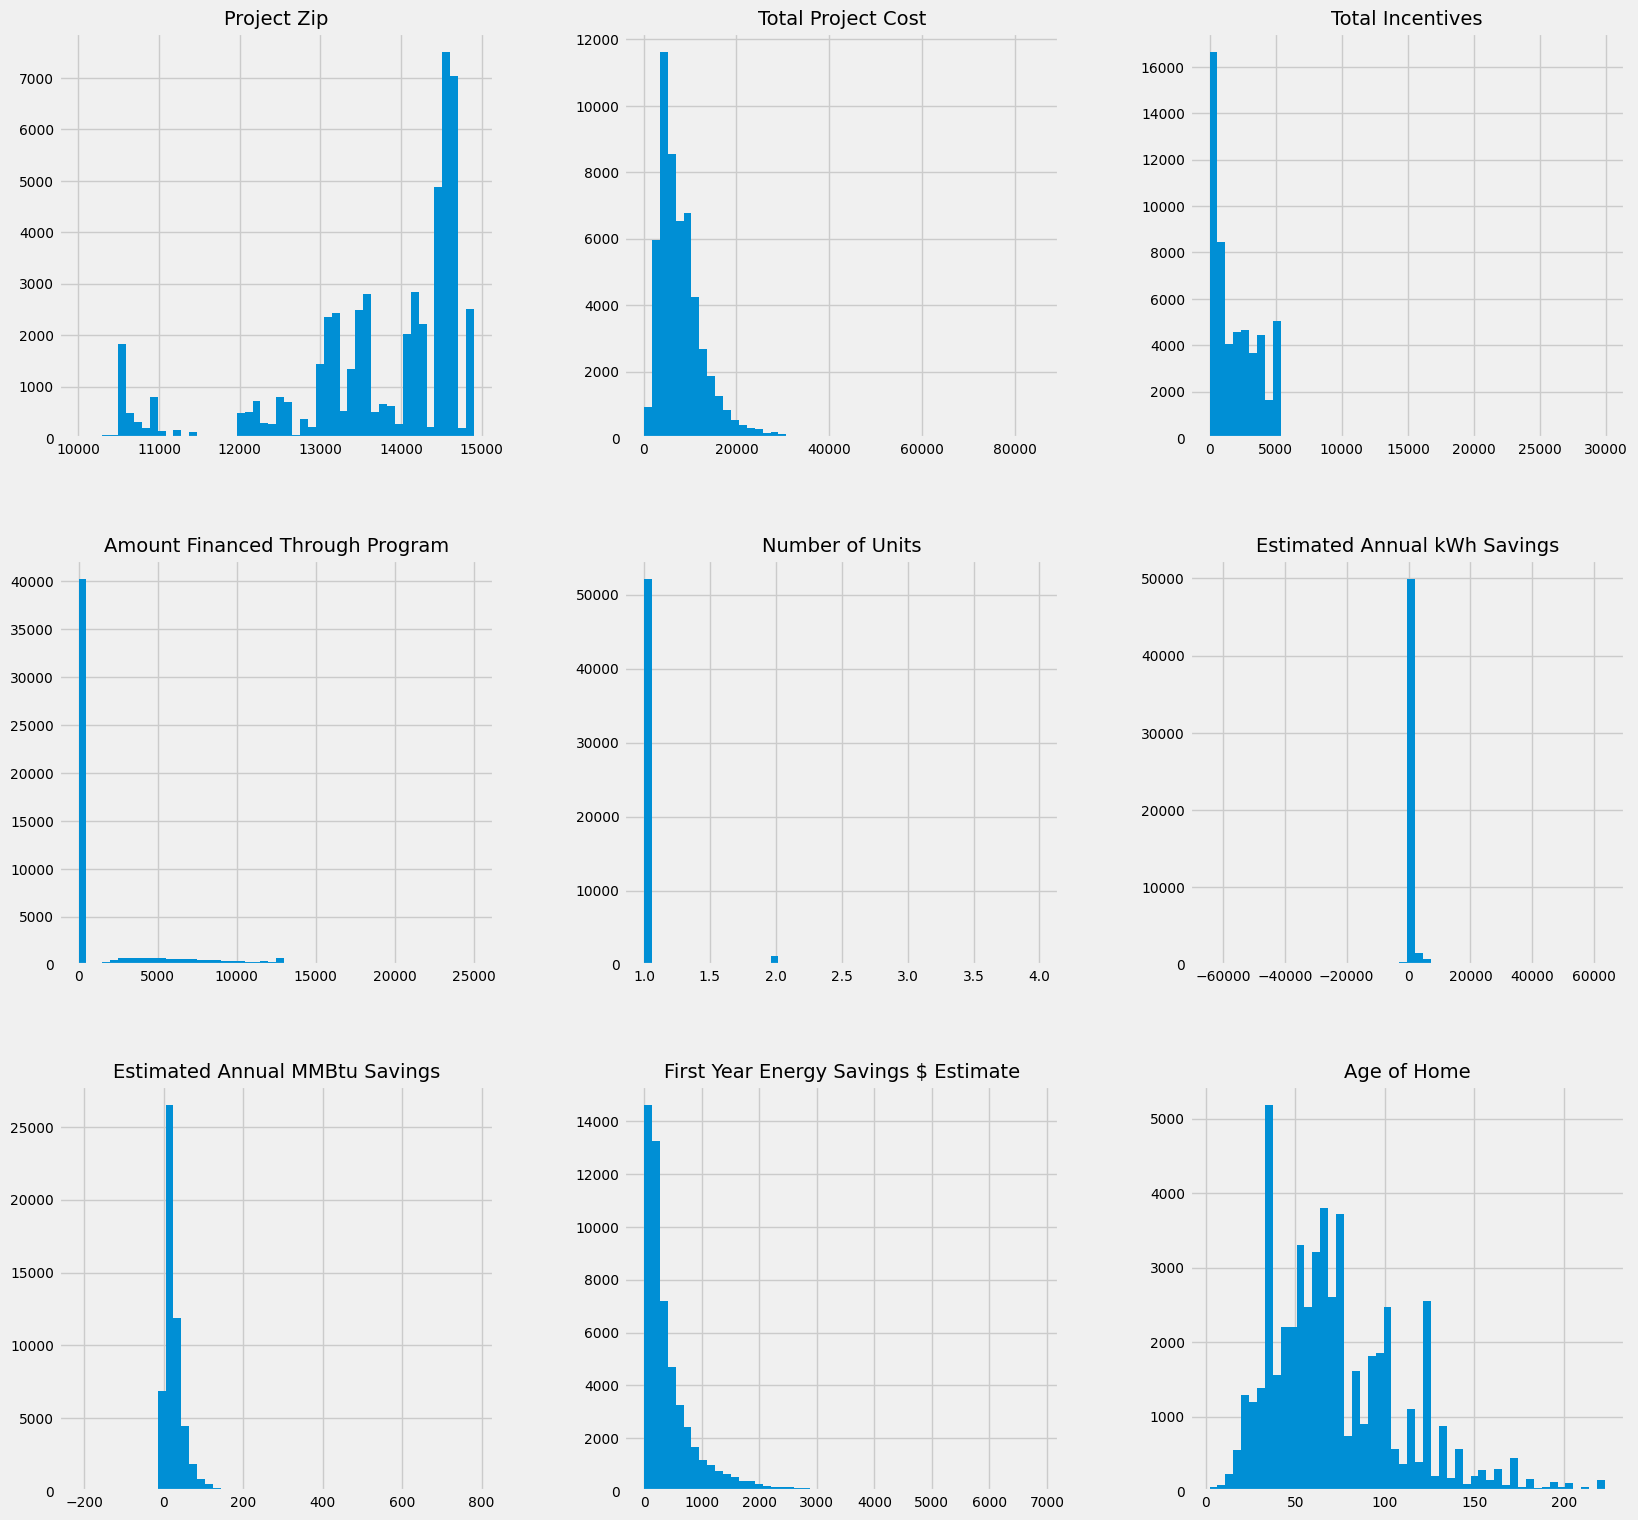

In [13]:
import matplotlib.pyplot as plt

# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

df.hist(bins=50, figsize=(18, 18))
plt.show()

In [14]:
df['Project County'].value_counts()

Project County
Monroe          14412
Erie             5829
Onondaga         4051
Oneida           3285
Jefferson        2966
Westchester      2741
Ontario          2115
Wayne            1447
Tompkins         1313
Niagara          1179
Livingston        997
Broome            871
Dutchess          870
Albany            808
Herkimer          660
Chemung           613
Oswego            604
Steuben           603
Rockland          572
Orange            568
Ulster            555
Madison           468
Cayuga            418
Rensselaer        372
Saratoga          368
Schenectady       323
Genesee           283
St. Lawrence      283
Cortland          260
Otsego            254
Seneca            251
Orleans           233
Chautauqua        223
Franklin          221
Tioga             200
Yates             182
Sullivan          178
Kings             161
Chenango          158
Columbia          148
Wyoming           146
Queens            145
Schuyler          139
Warren            124
Putnam           

In [15]:
# Simplifying the County Column
county_counts = df['Project County'].value_counts()
small_counties = county_counts[county_counts < 1000].index
df['Project County'] = df['Project County'].replace(small_counties, 'Other')

In [16]:
df['Project County'].value_counts()

Project County
Monroe         14412
Other          14319
Erie            5829
Onondaga        4051
Oneida          3285
Jefferson       2966
Westchester     2741
Ontario         2115
Wayne           1447
Tompkins        1313
Niagara         1179
Name: count, dtype: int64

In [17]:
def convert_size_of_home(size):
    if isinstance(size, str):
        if 'SF Below 800' in size:
            return np.nan
        elif 'SF Above 4,000' in size:
            return np.nan
        else:
            try:
                return float(size.replace(',', ''))
            except ValueError:
                return np.nan
    else:
        return size

df['Size of Home'] = df['Size of Home'].apply(convert_size_of_home)

In [18]:
# Function to convert 'Volume of Home' values
def convert_volume_of_home(volume):
    if isinstance(volume, str):
        if volume == 'Good':
            return np.nan
        else:
            try:
                return float(volume.replace(',', ''))
            except ValueError:
                return np.nan
    else:
        return volume

# Apply the conversion function to the 'Volume of Home' column
df['Volume of Home'] = df['Volume of Home'].apply(convert_volume_of_home)

Checking the distribution of some potential stratification columns

In [19]:
print(df['Number of Units'].value_counts())
print(df["Pre-Retrofit Home Heating Fuel Type"].value_counts())
print(df["Low-Rise or Home Performance Indicator"].value_counts())

Number of Units
1.0    52125
2.0     1227
3.0      171
4.0      134
Name: count, dtype: int64
Pre-Retrofit Home Heating Fuel Type
Natural Gas        25153
Natural gas        14918
Oil                 7002
Propane             2784
Electricity         1087
Wood                 410
Wood Pellets         145
Kerosene             128
Coal                  32
Bituminous Coal        7
Anthracite Coal        5
Electric               1
Name: count, dtype: int64
Low-Rise or Home Performance Indicator
Home Performance    48738
Low-Rise             4919
Name: count, dtype: int64


In [20]:
df["Pre-Retrofit Home Heating Fuel Type"].replace('Electric', 'Electricity', inplace=True)
print(df["Pre-Retrofit Home Heating Fuel Type"].value_counts())

Pre-Retrofit Home Heating Fuel Type
Natural Gas        25153
Natural gas        14918
Oil                 7002
Propane             2784
Electricity         1088
Wood                 410
Wood Pellets         145
Kerosene             128
Coal                  32
Bituminous Coal        7
Anthracite Coal        5
Name: count, dtype: int64


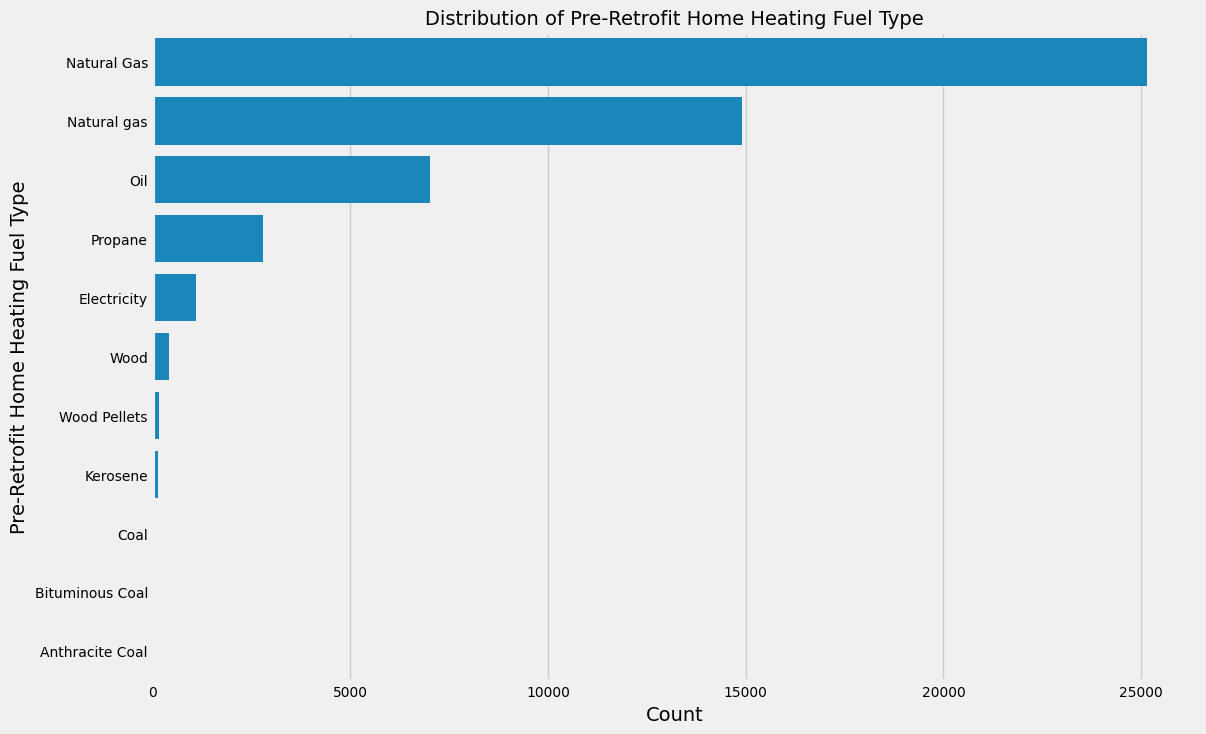

In [21]:
plt.figure(figsize=(12, 8))
sns.countplot(y="Pre-Retrofit Home Heating Fuel Type", data=df, order=df["Pre-Retrofit Home Heating Fuel Type"].value_counts().index)
plt.title("Distribution of Pre-Retrofit Home Heating Fuel Type")
plt.xlabel("Count")
plt.ylabel("Pre-Retrofit Home Heating Fuel Type")
plt.show()

Observation: Conducting a stratified split based on the 'Pre-Retrofit Home Heating Fuel Type' column, as it is likely to have a significant impact on energy savings (Fuel conversions (e.g., switching from oil to electricity) can cause significant changes in savings). Prior to splitting, filling the missing values in the column with a placeholder value (e.g., "Unknown").

In [22]:
df["Pre-Retrofit Home Heating Fuel Type"].fillna("Unknown", inplace=True)


## Examining Correlations

In [23]:
corr_matrix = df.corr(numeric_only=True)

In [24]:
corr_matrix['First Year Energy Savings $ Estimate'].sort_values(ascending=False)

First Year Energy Savings $ Estimate    1.000000
Estimated Annual MMBtu Savings          0.653646
Total Project Cost                      0.552391
Amount Financed Through Program         0.454514
Size of Home                            0.240263
Volume of Home                          0.215440
Age of Home                             0.199628
Total Incentives                        0.165558
Estimated Annual kWh Savings            0.160511
Number of Units                         0.020673
Project Zip                            -0.355112
Name: First Year Energy Savings $ Estimate, dtype: float64

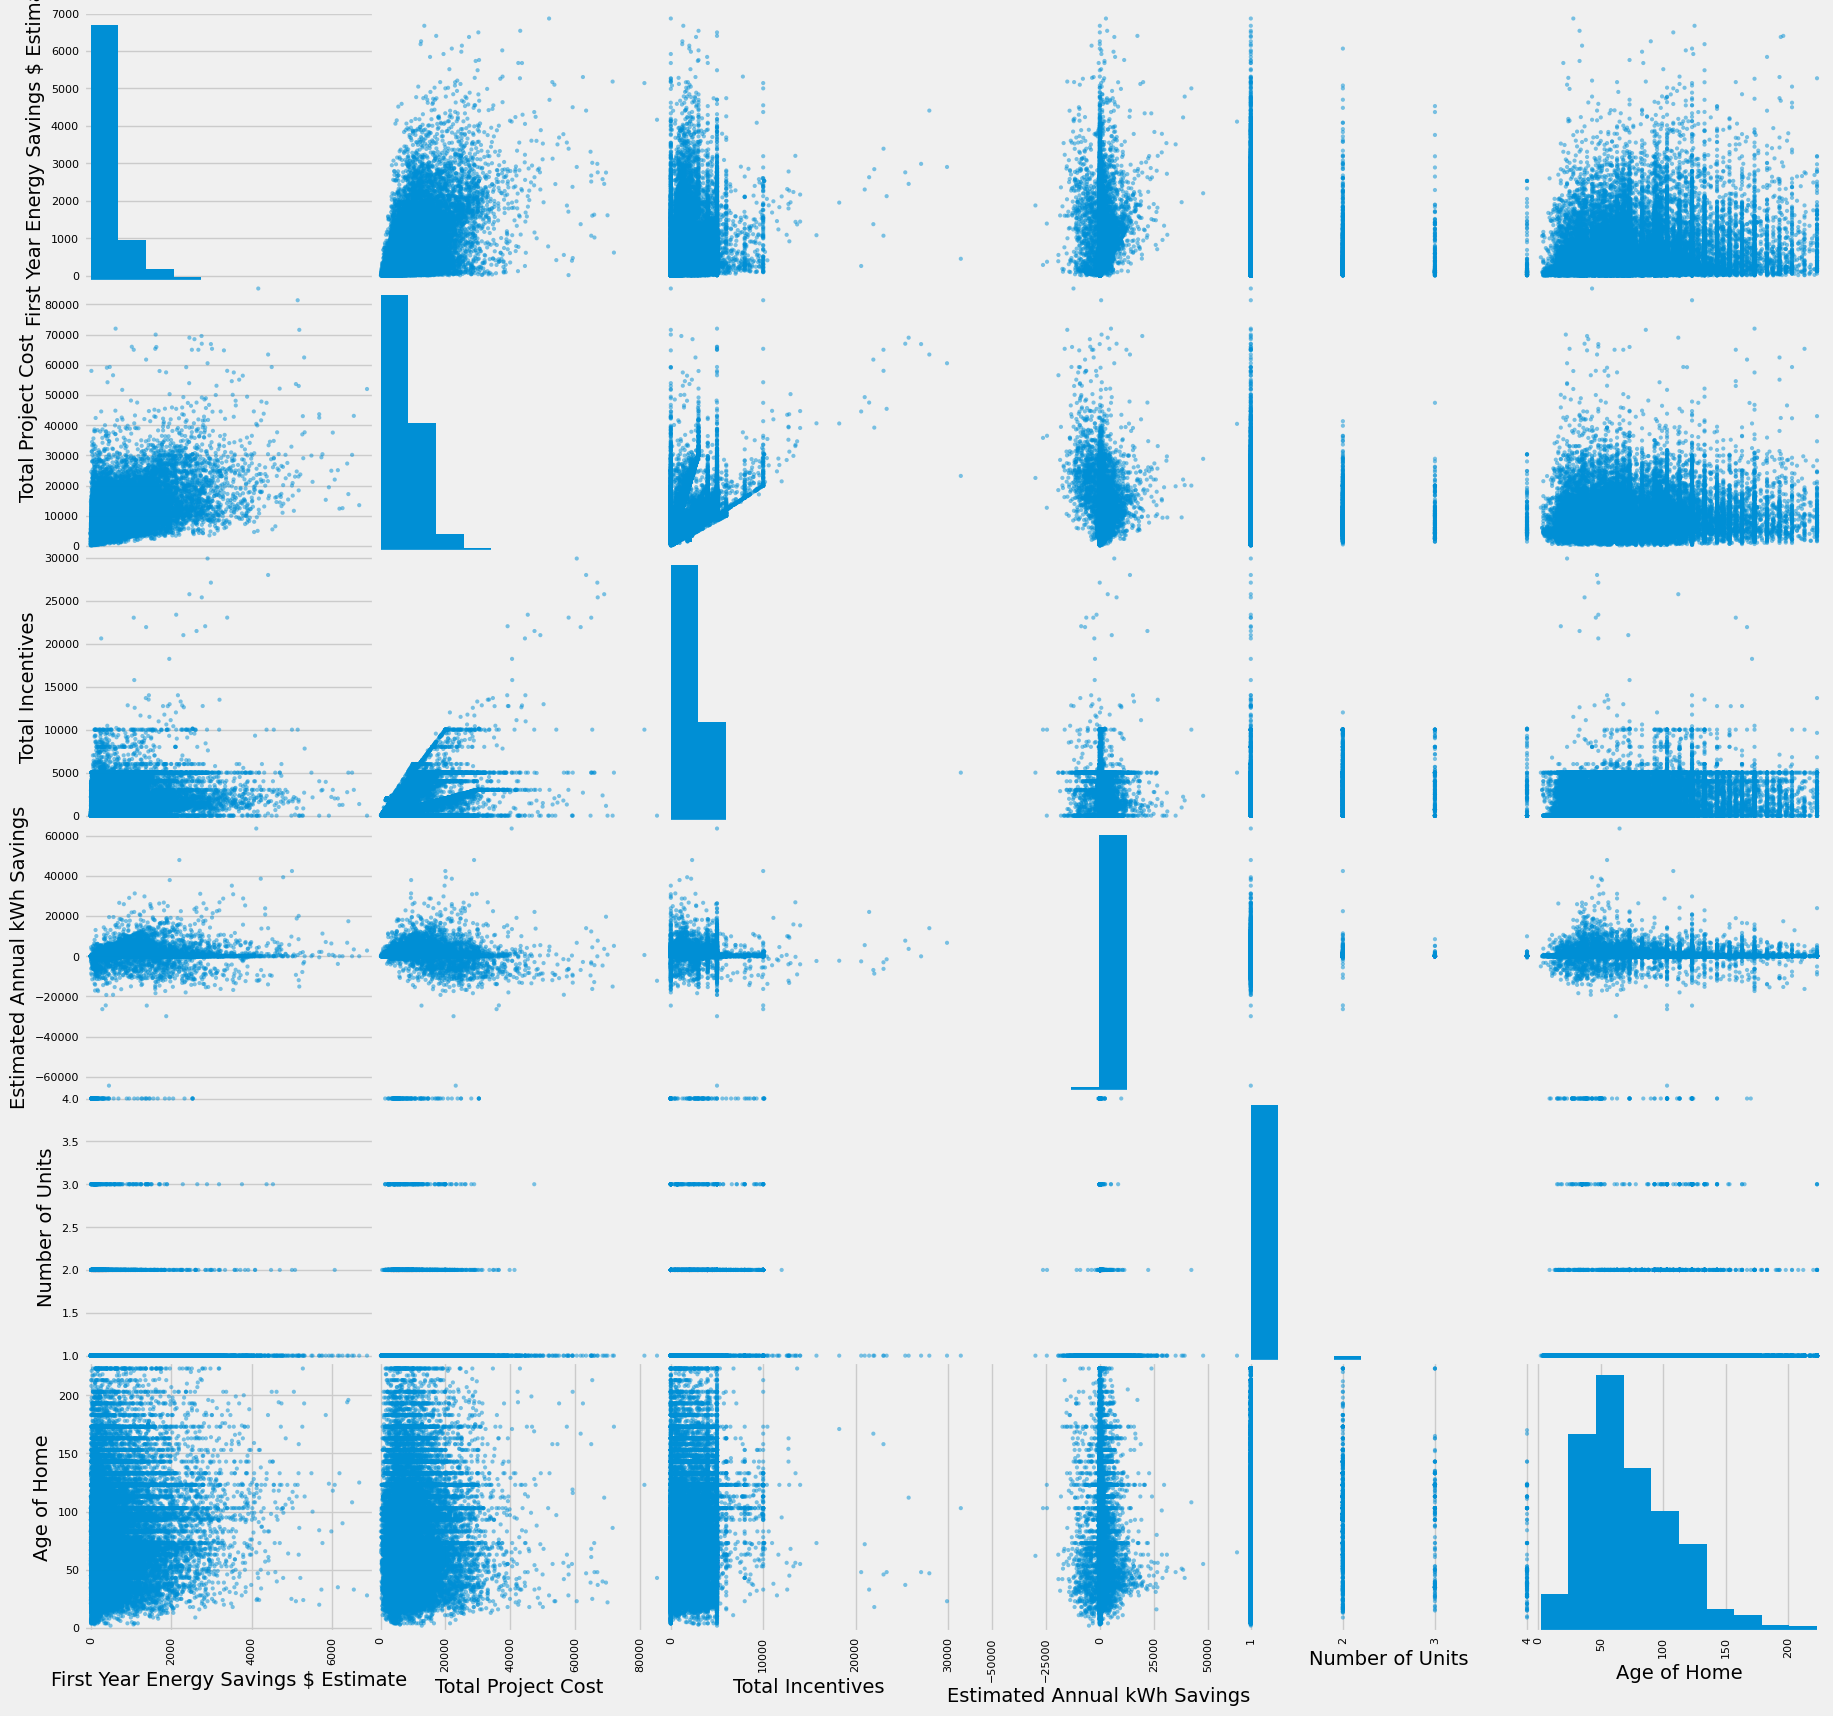

In [25]:
from pandas.plotting import scatter_matrix

attributes = ["First Year Energy Savings $ Estimate", "Total Project Cost", 
              'Total Incentives', 'Estimated Annual kWh Savings', 'Number of Units', 'Age of Home']
scatter_matrix(df[attributes], figsize=(20, 20))
plt.show()

In [26]:
zero_incentives_by_customer_type = df[df['Total Incentives'] == 0].groupby('Customer Type').size()
print(zero_incentives_by_customer_type)

Customer Type
Assisted      10
Market      9454
dtype: int64


In [27]:
zero_incentives_by_customer_type = df[df['Amount Financed Through Program'] == 0].groupby('Customer Type').size()
print(zero_incentives_by_customer_type)

Customer Type
Assisted    22410
Market      17838
dtype: int64


# Custom transformer to add new features

- Creating Interaction Term between 'Total Incentives' and 'Customer Type' to allow the model to learn (i) the effect of receiving any incentive and (ii) the additional impact of incentive amount.

- Creating Interaction Term between 'Program_Financing_Used' and 'Amount Financed Through Program' to allow the model to learn (i) the effect of receiving program financing.

In [28]:
# Custom transformer to add new features
class FeatureAdder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Convert Customer Type to numeric
        X['Customer_Type_Num'] = X['Customer Type'].apply(lambda x: 1 if x == 'Assisted' else 0)

        # Create the interaction term
        X['Incentive_Customer_Interaction'] = X['Total Incentives'] * X['Customer_Type_Num']

        # Create binary indicator for whether program financing was used
        X['Program_Financing_Used'] = X['Type of Program Financing'].notnull().astype(int)

        # Interaction with Amount Financed
        X['Financing_Amount_Interaction'] = X['Program_Financing_Used'] * X['Amount Financed Through Program']

        return X

## Outlier Examination
Applying Isolation Forest for outlier detection on 'Total Project Cost' as applying on all predictors might result in false positives due to features with zero (incentives and program financing)

In [29]:
# Extract feature as a 2D array
feature = df[["Total Project Cost"]].values  # Use double brackets to ensure it's 2D

# Initialize Isolation Forest
isolation_forest = IsolationForest(contamination=0.1, random_state=42)

# Fit the model and predict outliers
outlier_pred = isolation_forest.fit_predict(feature)

In [30]:
# Add outlier prediction to the DataFrame
df['Outlier'] = (outlier_pred == -1).astype(int)

# Separate outliers and non-outliers
outliers = df[df['Outlier'] == 1]
non_outliers = df[df['Outlier'] == 0]

# Check the number of outliers
print(f"Number of outliers: {outliers.shape[0]}")


Number of outliers: 5366


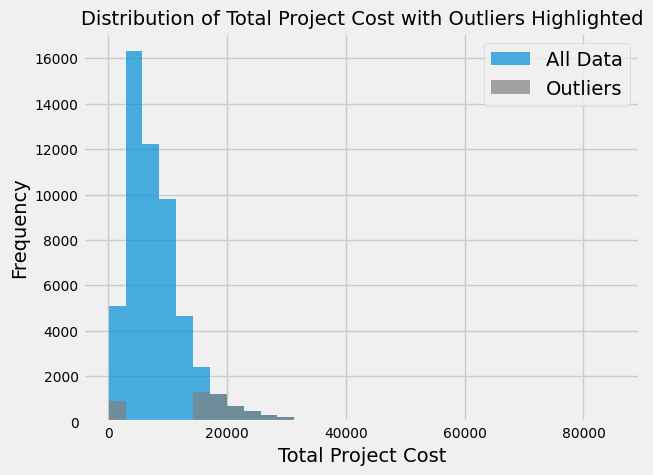

In [31]:
import matplotlib.pyplot as plt

plt.hist(df['Total Project Cost'], bins=30, alpha=0.7, label='All Data')
plt.hist(outliers['Total Project Cost'], bins=30, alpha=0.7, label='Outliers', color='grey')
plt.legend()
plt.xlabel('Total Project Cost')
plt.ylabel('Frequency')
plt.title('Distribution of Total Project Cost with Outliers Highlighted')
plt.show()


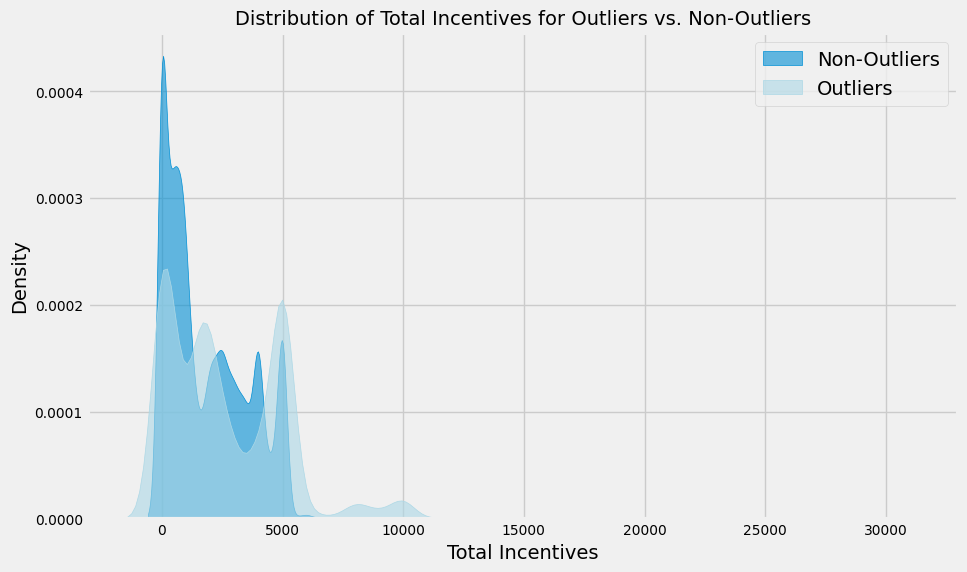

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distributions of a key predictor (example: Total Incentives)
plt.figure(figsize=(10, 6))
sns.kdeplot(non_outliers['Total Incentives'], label='Non-Outliers', fill=True, alpha=0.6)
sns.kdeplot(outliers['Total Incentives'], label='Outliers', fill=True, color='lightblue', alpha=0.6)
plt.title('Distribution of Total Incentives for Outliers vs. Non-Outliers')
plt.xlabel('Total Incentives')
plt.ylabel('Density')
plt.legend()
plt.show()


In [33]:
df['Total Project Cost'].describe()

count    53657.000000
mean      8180.470023
std       5511.254958
min         95.000000
25%       4600.000000
50%       6850.000000
75%      10279.000000
max      85290.000000
Name: Total Project Cost, dtype: float64

In [34]:
high_incentive_outliers = outliers[outliers['Total Incentives'] > 10000]
print(high_incentive_outliers[['Total Project Cost']].describe())

       Total Project Cost
count           43.000000
mean         41095.441860
std          13257.976965
min          21200.000000
25%          30342.000000
50%          39286.000000
75%          46462.500000
max          69000.000000


In [35]:
low_cost_outliers = outliers[outliers['Total Project Cost'] < 1000]
print(low_cost_outliers[['Total Incentives']].describe())

       Total Incentives
count        222.000000
mean         144.729730
std          154.934401
min            0.000000
25%           44.250000
50%           80.000000
75%          218.500000
max          498.000000


Observation: The outliers reflect valid scenarios, as higher costs are associated with higher incentives and the same applies to lower values. Therefore, they will be retained in the dataset.

Excluding columns that won't contribute meaningfully to the model. Also, the columns 'Estimated Annual kWh Savings' and 'Estimated Annual MMBtu Savings' are dropped to avoid data leakage, as they directly contribute to the computation of the target variable,'First Year Modeled Energy Savings $ Estimate'.

In [36]:
df = df.drop(columns=['Reporting Period', 'Home Performance Project ID', 'Home Performance Site ID', 'Project City', 'Project Zip', 'Project Completion Date', 'Homeowner Received Green Jobs-Green NY Free/Reduced Cost Audit (Y/N)','New Georeferenced Column', 'Outlier', 'Estimated Annual MMBtu Savings', 'Estimated Annual kWh Savings'])

In [37]:
# Separate the target variable
target_variable = 'First Year Energy Savings $ Estimate'
X = df.drop(columns=[target_variable])
y = df[target_variable]

In [38]:
summary = df.groupby('Customer Type')['Total Project Cost'].agg(
    mean='mean',
    std='std',
    min='min',
    max='max',
    count='count'
)

print(summary)

                      mean          std  min    max  count
Customer Type                                             
Assisted       7953.967838  5016.457227   95  81402  29165
Market         8450.188143  6036.914227  152  85290  24492


In [39]:
summary = df.groupby('Customer Type')['Total Incentives'].agg(
    mean='mean',
    std='std',
    min='min',
    max='max',
    count='count'
)

print(summary)

                      mean          std  min    max  count
Customer Type                                             
Assisted       3144.965987  1575.771346    0  29900  29165
Market          502.769762   610.624933    0   5000  24492


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=X["Pre-Retrofit Home Heating Fuel Type"], random_state=42)

print(X_test["Pre-Retrofit Home Heating Fuel Type"].value_counts() / len(X_test))

Pre-Retrofit Home Heating Fuel Type
Natural Gas        0.468785
Natural gas        0.278047
Oil                0.130451
Propane            0.051901
Unknown            0.036992
Electricity        0.020313
Wood               0.007641
Wood Pellets       0.002702
Kerosene           0.002423
Coal               0.000559
Bituminous Coal    0.000093
Anthracite Coal    0.000093
Name: count, dtype: float64


In [41]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42925 entries, 20715 to 29137
Data columns (total 15 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Project County                          42925 non-null  object 
 1   Gas Utility                             34319 non-null  object 
 2   Electric Utility                        42925 non-null  object 
 3   Customer Type                           42925 non-null  object 
 4   Low-Rise or Home Performance Indicator  42925 non-null  object 
 5   Total Project Cost                      42925 non-null  int64  
 6   Total Incentives                        42925 non-null  int64  
 7   Type of Program Financing               10936 non-null  object 
 8   Amount Financed Through Program         42925 non-null  int64  
 9   Pre-Retrofit Home Heating Fuel Type     42925 non-null  object 
 10  Size of Home                            41328 non-null  flo

## Transformation Pipeline

In [42]:
# Apply FeatureAdder before other transformations
feature_adder_pipeline = Pipeline([
    ('feature_adder', FeatureAdder()),
])

# First, apply the feature adder pipeline to the training data
X_train_added_features = feature_adder_pipeline.fit_transform(X_train)
X_test_added_features = feature_adder_pipeline.transform(X_test)

# Verify the new features added
print("X_train with added features:\n", X_train_added_features[:5])

X_train with added features:
       Project County                     Gas Utility  \
20715          Other   New York State Electric & Gas   
61977       Onondaga                   National Grid   
9322            Erie  National Fuel Gas Distribution   
55925           Erie  National Fuel Gas Distribution   
28116         Monroe        Rochester Gas & Electric   

                    Electric Utility Customer Type  \
20715  New York State Electric & Gas      Assisted   
61977                  National Grid      Assisted   
9322                   National Grid      Assisted   
55925                  National Grid        Market   
28116       Rochester Gas & Electric      Assisted   

      Low-Rise or Home Performance Indicator  Total Project Cost  \
20715                       Home Performance               14060   
61977                       Home Performance                9014   
9322                        Home Performance               14588   
55925                       Home Per

In [43]:
# Numerical pipeline (imputing missing values with the median)
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
])

# Categorical pipeline (imputing missing values with the most frequent value, then encoding)
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore')),
])

# Combine custom transformers with existing numerical and categorical pipelines
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, [
        'Size of Home', 'Volume of Home', 'Total Project Cost', 
        'Total Incentives', 'Amount Financed Through Program', 
        'Number of Units', 'Age of Home',
        'Incentive_Customer_Interaction', 'Financing_Amount_Interaction'
    ]),
    ("cat", cat_pipeline, [
        'Project County', 'Gas Utility', 'Electric Utility', 
        'Customer Type', 'Low-Rise or Home Performance Indicator', 
        'Pre-Retrofit Home Heating Fuel Type', 'Measure Type', 
        'Type of Program Financing'
    ]),
])

# Fit and transform the data
X_train_prepared = full_pipeline.fit_transform(X_train_added_features)
X_test_prepared = full_pipeline.transform(X_test_added_features)

# Retrieve the feature names from the full pipeline
feature_names = full_pipeline.get_feature_names_out()

# Convert the transformed data back to a DataFrame with proper column names
X_train_prepared_df = pd.DataFrame(X_train_prepared, columns=feature_names)
X_test_prepared_df = pd.DataFrame(X_test_prepared, columns=feature_names)

# Verify that the new DataFrame has proper column names
print("Transformed X_train:\n", X_train_prepared_df.head())
print("Feature names assigned correctly:", X_train_prepared_df.columns)


# Verify the new features
print("Transformed X_train:\n", X_train_prepared_df.head())
print("Transformed X_test:\n", X_test_prepared_df.head())

Transformed X_train:
    num__Size of Home  num__Volume of Home  num__Total Project Cost  \
0             2016.0               8064.0                  14060.0   
1             2106.0              16848.0                   9014.0   
2             1657.0              51624.0                  14588.0   
3             1840.0              13800.0                   6757.0   
4              897.0              14592.0                   6116.0   

   num__Total Incentives  num__Amount Financed Through Program  \
0                 4000.0                               10060.0   
1                 4507.0                                   0.0   
2                 7294.0                                   0.0   
3                  676.0                                6057.0   
4                 1752.0                                   0.0   

   num__Number of Units  num__Age of Home  \
0                   1.0              64.0   
1                   1.0              60.0   
2                   4.0  

## Causal ML Analysis: Assisted vs. Market Treatment Effects

This analysis explores the impact of assisted vs. market rate incentives on project outcomes using Causal ML methods. S-Learner and X-Learner has been applied using different base models: Linear Regression, XGBoost, and Random Forest (as it was used on assignment 1). 

As the 'Pre-Retrofit Home Heating Fuel Type' was proven to be the most important feature (both in Assignment 1 analysis and Assignment 2 - S-learner feature importances), the study focused on treatment effect heterogeneity by using 'Pre-Retrofit Home Heating Fuel Type' as an effect modifier in X-Learner and estimating treatment effects separately across fuel types.

As S-Learners can't explicitly model instruments or effect modifiers like X-Learners, used X-Learner to explore treatment effect heterogeneity by heating fuel type. X-Learner estimated separate models for treated and control groups, then learnt how treatment effects vary based on key variables like fuel type. This helps identify whether incentives work better for certain heating sources.


_______
**Question:** 
1. Should Incentives Be Adjusted Based on Heating Fuel Type?
2. Do energy savings from financial incentives vary across different pre-retrofit heating fuel types? 

**Hypothesis:** 

The effectiveness of financial incentives will depend on the original heating fuel type, meaning certain households (e.g., those using oil or propane) will see higher energy savings when receiving assisted incentives.


**Expected Insights:**
- The treatment effect will vary across heating fuel types, meaning incentives are more effective for some groups.
- If a specific fuel type (e.g., oil heating) benefits the most, it suggests tailoring incentives to maximize impact.
- Different fuel types likely respond differently to incentives (e.g., switching from oil to electric might yield larger savings than upgrading an already efficient system).


_______________
**Causal ML:**

 This section reuses the preprocessed training data from Assignment 1. 

   - X_causal: **the confounders** (all features, as transformed by full pipeline)
   - w_causal: **the treatment indicator** ("Customer Type" - Assisted vs. Market Rate Incentive - based on household income level)
   - y_causal: **the outcome variable** (First Year Energy Savings $ Estimate)

   For X_Learner: **the effect modifier** ('Pre-Retrofit Home Heating Fuel Type')

   **DoWhy:**

   - w_causal: **the treatment indicator** ("Total Incentives" - continuous variable, Causal ML analyses incentives using the categorical feature - Assisted vs. Market Rate, while DoWhy will analyse incentive effects using the continuous variable to be able to capture the range of change in treatment)

In [44]:
X_causal = X_train_prepared_df.copy()  

# Defining the treatment indicator - Customer Type
w_causal = X_train_added_features['Customer Type'] \
    .apply(lambda x: 'treatment' if x.strip().lower() == 'assisted' else 'control').values

# Outcome variable - First Year Energy Savings $ Estimate
y_causal = y_train.values

print("Causal dataset shapes:")
print("  Confounders (X_causal):", X_causal.shape)
print("  Outcome (y_causal):", y_causal.shape)
print("  Treatment (w_causal) unique values:", np.unique(w_causal))

Causal dataset shapes:
  Confounders (X_causal): (42925, 64)
  Outcome (y_causal): (42925,)
  Treatment (w_causal) unique values: ['control' 'treatment']


## Experiment 1: S-Learner with Random Forest Regressor

In [46]:
# Initialize a RandomForestRegressor as your base learner.
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Create the S-learner using the random forest model.
s_learner = BaseSRegressor(rf_model, control_name='control')

# Estimate the ATE using the new S-learner.
ate_s_rf = s_learner.estimate_ate(X=X_causal, treatment=w_causal, y=y_causal)
print("ATE estimate (S-Learner with Random Forest):", ate_s_rf)

# Fit and predict individual treatment effects.
s_learner_tau = s_learner.fit_predict(X=X_causal, treatment=w_causal, y=y_causal)

# Retrieve the feature names from your full pipeline (which was used to produce X_train_prepared)
transformed_feature_names = full_pipeline.get_feature_names_out()
print("Transformed feature names:", transformed_feature_names)
print("Number of transformed features:", len(transformed_feature_names))

# Feature Importance (using the built-in "auto" method)
fi_s_auto = s_learner.get_importance(
    X=X_causal,               # X_causal is the transformed data (e.g., X_train_prepared_df)
    tau=s_learner_tau,        # individual treatment effect estimates
    normalize=True,
    method='auto',
    features=transformed_feature_names.tolist()  
)
print("\nS-Learner Feature Importance (auto):")
print(fi_s_auto)


ATE estimate (S-Learner with Random Forest): [-7.69690532]
Transformed feature names: ['num__Size of Home' 'num__Volume of Home' 'num__Total Project Cost'
 'num__Total Incentives' 'num__Amount Financed Through Program'
 'num__Number of Units' 'num__Age of Home'
 'num__Incentive_Customer_Interaction' 'num__Financing_Amount_Interaction'
 'cat__Project County_Erie' 'cat__Project County_Jefferson'
 'cat__Project County_Monroe' 'cat__Project County_Niagara'
 'cat__Project County_Oneida' 'cat__Project County_Onondaga'
 'cat__Project County_Ontario' 'cat__Project County_Other'
 'cat__Project County_Tompkins' 'cat__Project County_Wayne'
 'cat__Project County_Westchester'
 'cat__Gas Utility_Central Hudson Gas & Electric'
 'cat__Gas Utility_Consolidated Edison'
 'cat__Gas Utility_Corning Natural Gas' 'cat__Gas Utility_KeySpan Energy'
 'cat__Gas Utility_Long Island Power Authority'
 'cat__Gas Utility_Multiple Gas Providers'
 'cat__Gas Utility_National Fuel Gas Distribution'
 'cat__Gas Utility_Nat

Financing_Amount_Interaction              0.000000
Measure Type                              0.000052
Customer Type                             0.000106
Number of Units                           0.000262
Low-Rise or Home Performance Indicator    0.001115
Type of Program Financing                 0.004925
Electric Utility                          0.012018
Size of Home                              0.017810
Gas Utility                               0.019919
Project County                            0.021073
Volume of Home                            0.041171
Amount Financed Through Program           0.049363
Total Incentives                          0.091177
Age of Home                               0.098283
Incentive_Customer_Interaction            0.156519
Total Project Cost                        0.229647
Pre-Retrofit Home Heating Fuel Type       0.256560
dtype: float64


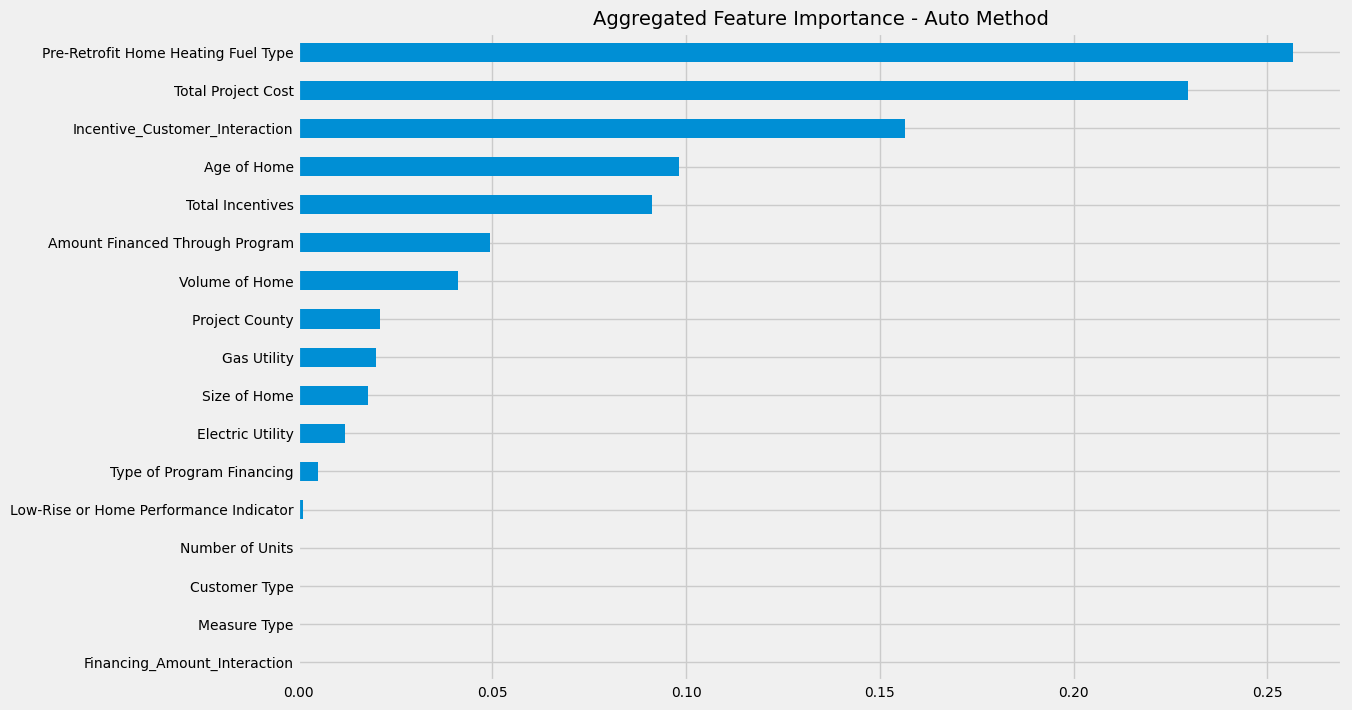

In [47]:
fi_s_auto_series = fi_s_auto['treatment']  # This is now a Pandas Series of feature importances

def get_original_var(feature_name):
    if feature_name.startswith("cat__"):
        # Remove the "cat__" prefix and then split at the first underscore.
        # Adjust the splitting logic if needed.
        return feature_name[len("cat__"):].split("_")[0]
    else:
        return feature_name.replace("num__", "")

aggregated_importance = {}
for feature, imp in fi_s_auto_series.items():
    original_var = get_original_var(feature)
    aggregated_importance[original_var] = aggregated_importance.get(original_var, 0) + imp

aggregated_importance_series = pd.Series(aggregated_importance).sort_values(ascending=True)
print(aggregated_importance_series)
aggregated_importance_series.plot(kind='barh', figsize=(12,8), title='Aggregated Feature Importance - Auto Method')
plt.show()


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

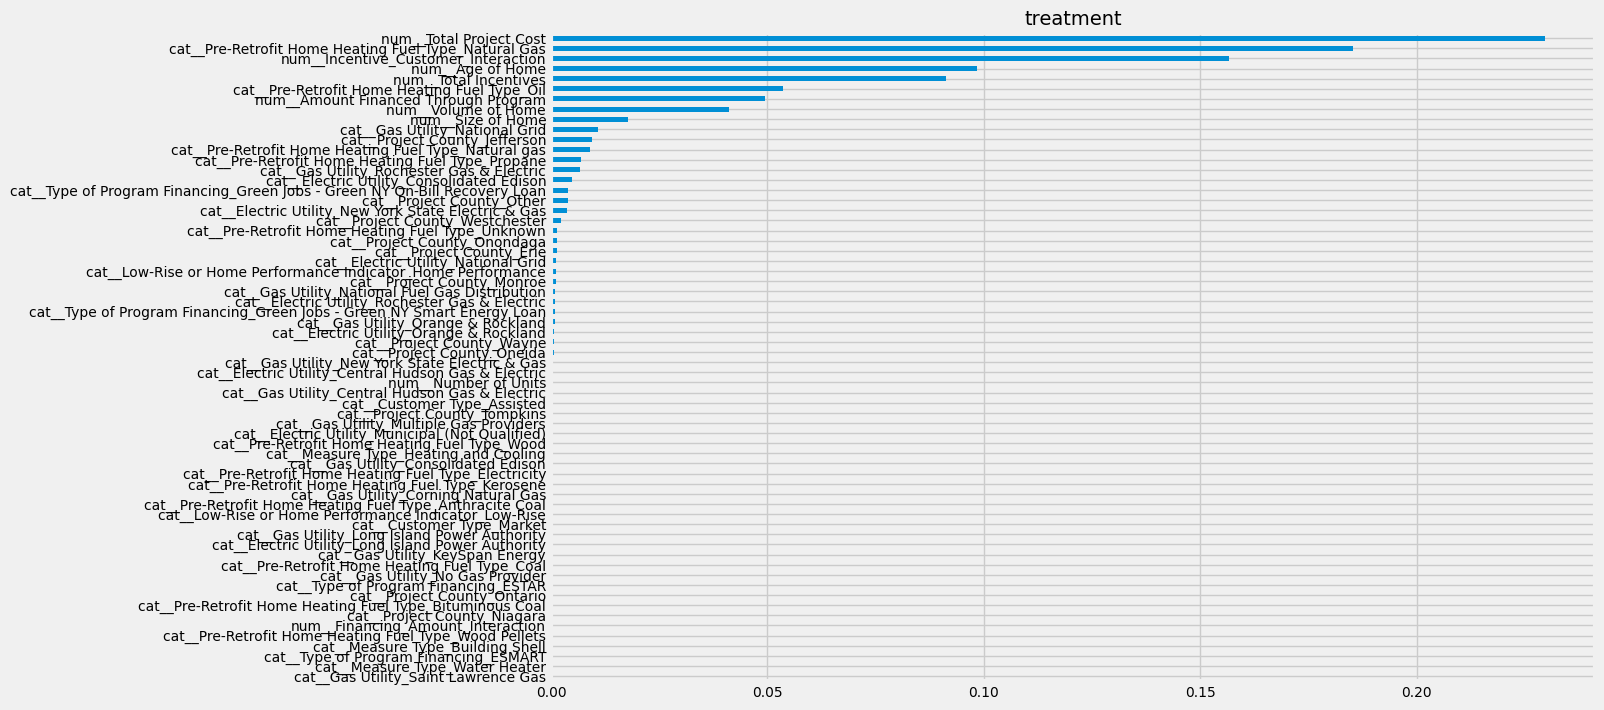

In [48]:
# Plot the feature importance.
s_learner.plot_importance(
    X=X_causal,
    tau=s_learner_tau,
    normalize=True,
    method='auto',
    features=transformed_feature_names.tolist()
)
plt.show()


Note: Combining importances under general feature name to make it interpretable for feature importance.

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

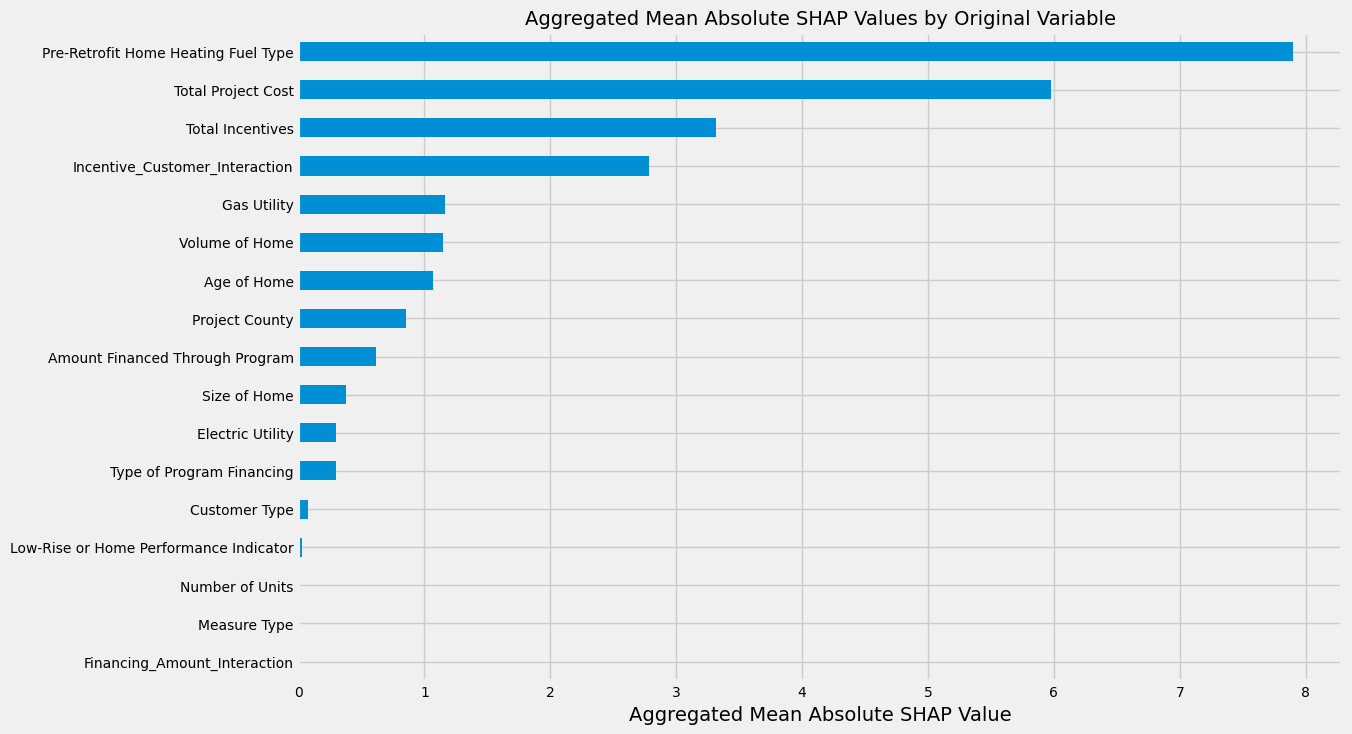

In [61]:
# Assume you already generated SHAP values as follows:
shap_s = s_learner.get_shap_values(X=X_causal, tau=s_learner_tau)
print("\nMean absolute SHAP values for S-Learner (raw per feature):")
print(np.mean(np.abs(shap_s['treatment']), axis=0))

# Compute the mean absolute SHAP value for each transformed feature.
# transformed_feature_names should be obtained from your full pipeline.
mean_abs_shap = np.mean(np.abs(shap_s['treatment']), axis=0)
shap_series = pd.Series(mean_abs_shap, index=transformed_feature_names.tolist())
print("\nMean absolute SHAP values (per transformed feature):")
print(shap_series)

# Define a helper function to get the original variable name.
def get_original_var(feature_name):
    if feature_name.startswith("cat__"):
        # Example: "cat__Project County_Erie" -> "Project"
        # (You may need to adjust the splitting logic if your original variable name includes spaces.)
        return feature_name[len("cat__"):].split("_")[0]
    else:
        return feature_name.replace("num__", "")

# Aggregate the mean absolute SHAP values by original variable.
aggregated_shap = {}
for feature, value in shap_series.items():
    orig_var = get_original_var(feature)
    aggregated_shap[orig_var] = aggregated_shap.get(orig_var, 0) + value

aggregated_shap_series = pd.Series(aggregated_shap).sort_values(ascending=True)
print("\nAggregated Mean Absolute SHAP Values by Original Variable:")
print(aggregated_shap_series)

# Plot the aggregated SHAP values.
plt.figure(figsize=(12,8))
aggregated_shap_series.plot(kind='barh', title='Aggregated Mean Absolute SHAP Values by Original Variable')
plt.xlabel("Aggregated Mean Absolute SHAP Value")
plt.show()


In [50]:
# =============================================================================
# ## 2. Permutation Importance on the S-Learner
# =============================================================================
from sklearn.inspection import permutation_importance

# Split the estimated treatment effects (tau) into training and testing sets.
X_train_c, X_test_c, tau_train_c, tau_test_c = train_test_split(
    X_causal, s_learner_tau, test_size=0.3, random_state=42
)

# Fit the base  model on the training split (with tau as the target).
model_tau_fit = rf_model.fit(X_train_c, tau_train_c)

# Compute permutation importance on the test set.
perm_imp = permutation_importance(
    estimator=model_tau_fit,
    X=X_test_c,
    y=tau_test_c,
    random_state=42
)
# For display, we use the original column names from the feature-adder DataFrame.
fi_perm = pd.Series(perm_imp.importances_mean, index=transformed_feature_names.tolist()).sort_values(ascending=False)
print("\nPermutation Importance (Test Set) for S-Learner:")
print(fi_perm)



Permutation Importance (Test Set) for S-Learner:
num__Total Project Cost                                                       7.771376e-01
cat__Pre-Retrofit Home Heating Fuel Type_Natural Gas                          5.975873e-01
num__Incentive_Customer_Interaction                                           4.278617e-01
num__Total Incentives                                                         2.003630e-01
num__Age of Home                                                              1.516060e-01
cat__Pre-Retrofit Home Heating Fuel Type_Oil                                  1.437729e-01
num__Volume of Home                                                           7.607941e-02
cat__Project County_Jefferson                                                 4.071417e-02
cat__Pre-Retrofit Home Heating Fuel Type_Natural gas                          3.742845e-02
num__Size of Home                                                             3.407101e-02
cat__Gas Utility_National Grid          

Measure Type                             -0.000043
Customer Type                            -0.000041
Low-Rise or Home Performance Indicator    0.000401
Number of Units                           0.000876
Type of Program Financing                 0.006682
Electric Utility                          0.012386
Amount Financed Through Program           0.025022
Financing_Amount_Interaction              0.026170
Size of Home                              0.034071
Project County                            0.053285
Gas Utility                               0.059626
Volume of Home                            0.076079
Age of Home                               0.151606
Total Incentives                          0.200363
Incentive_Customer_Interaction            0.427862
Total Project Cost                        0.777138
Pre-Retrofit Home Heating Fuel Type       0.794534
dtype: float64


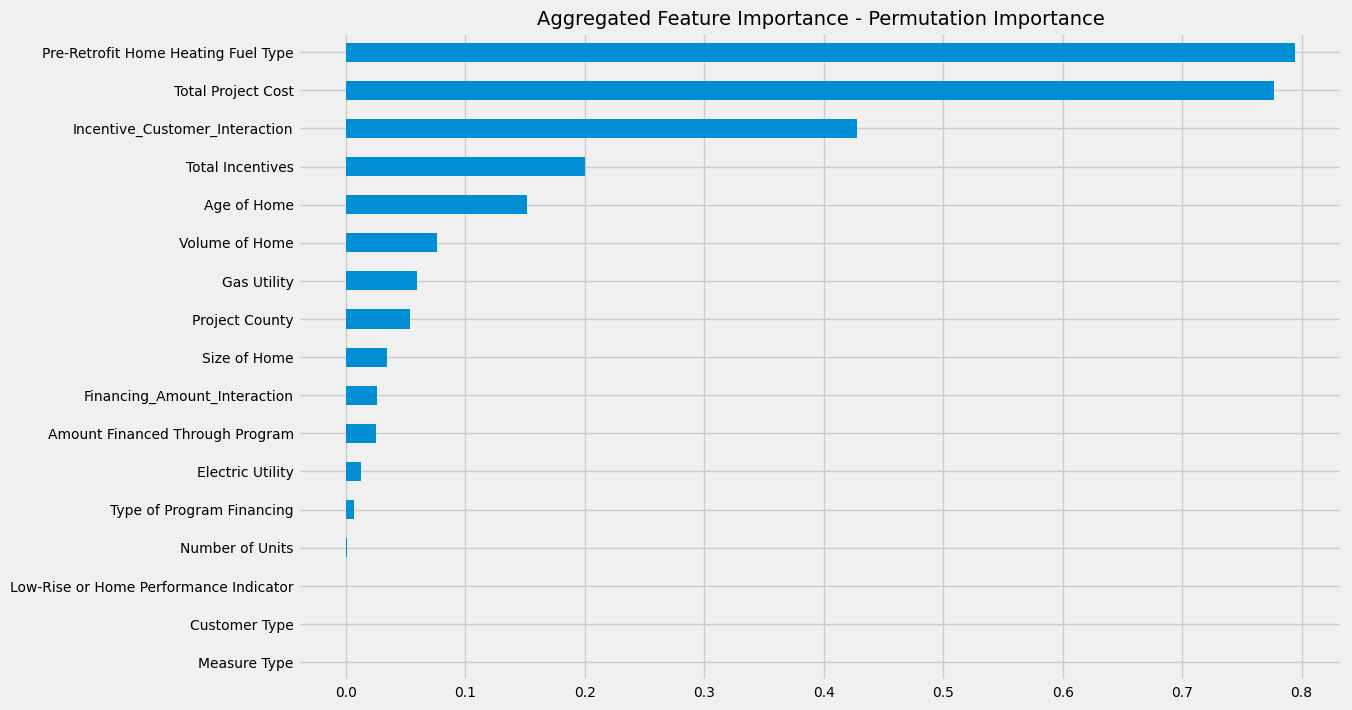

In [51]:
# A more robust way might be to remove the prefix:
def get_original_var(feature_name):
    if feature_name.startswith("cat__"):
        # Remove the "cat__" prefix and then split at the first underscore
        # Assuming the original variable name doesn't have underscores
        return feature_name[len("cat__"):].split("_")[0]
    else:
        return feature_name.replace("num__", "")

aggregated_importance = {}
for feature, imp in fi_perm.items():
    original_var = get_original_var(feature)
    aggregated_importance[original_var] = aggregated_importance.get(original_var, 0) + imp
aggregated_importance_series = pd.Series(aggregated_importance).sort_values(ascending=True)
print(aggregated_importance_series)
aggregated_importance_series.plot(kind='barh', figsize=(12,8), title='Aggregated Feature Importance - Permutation Importance')
plt.show()


## Experiment 2: S-Learner with Linear Regression (LRSRegressor)

In [52]:
# Initialize the linear regression model.
lr_model = LinearRegression()

# Create the S-learner using the linear model.
s_learner_lr = BaseSRegressor(lr_model, control_name='control')

# Estimate the Average Treatment Effect (ATE).
ate_lr = s_learner_lr.estimate_ate(X=X_causal, treatment=w_causal, y=y_causal)
print("ATE estimate (S-Learner with Linear Regression):", ate_lr)

# Fit the S-learner and obtain individual treatment effects.
tau_lr = s_learner_lr.fit_predict(X=X_causal, treatment=w_causal, y=y_causal)

# Retrieve feature importance using the built-in "auto" method.
# Here, we use the transformed feature names from your full pipeline.
fi_lr_auto = s_learner_lr.get_importance(
    X=X_causal,
    tau=tau_lr,
    normalize=True,
    method='auto',
    features=transformed_feature_names.tolist()
)
print("\nS-Learner Feature Importance (auto) with Linear Regression:")
print(fi_lr_auto)

# Optionally, aggregate the importance for categorical variables.
# (See the aggregation code below for an example.)
def get_original_var(feature_name):
    if feature_name.startswith("cat__"):
        # Remove the "cat__" prefix and take the part before the first underscore.
        return feature_name[len("cat__"):].split("_")[0]
    else:
        return feature_name.replace("num__", "")


ATE estimate (S-Learner with Linear Regression): [1.64624276]
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped

In [53]:
# Retrieve feature importance using the built-in "auto" method
fi_lr_auto = s_learner_lr.get_importance(
    X=X_causal,
    tau=tau_lr,
    normalize=True,
    method='auto',
    features=transformed_feature_names.tolist()
)
print("\nS-Learner Feature Importance (auto) with Linear Regression:")
print(fi_lr_auto)


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

In [54]:
# Extract the Series from the auto importance (assuming it's under key "treatment")
import numpy as np
print("Mean of tau:", np.mean(s_learner_tau))
print("Std of tau:", np.std(s_learner_tau))

Mean of tau: -7.696905318839663
Std of tau: 20.47727928142119



Permutation Importance (LR S-Learner):
cat__Gas Utility_Rochester Gas & Electric                                     3.101577e-02
cat__Gas Utility_National Grid                                                2.816375e-02
cat__Gas Utility_National Fuel Gas Distribution                               2.385570e-02
cat__Gas Utility_New York State Electric & Gas                                1.085742e-02
cat__Gas Utility_Consolidated Edison                                          2.938564e-03
cat__Measure Type_Heating and Cooling                                         2.813828e-03
num__Incentive_Customer_Interaction                                           2.679139e-03
cat__Gas Utility_Central Hudson Gas & Electric                                2.268206e-03
num__Total Incentives                                                         1.775960e-03
cat__Gas Utility_Corning Natural Gas                                          1.590099e-03
cat__Gas Utility_Orange & Rockland                

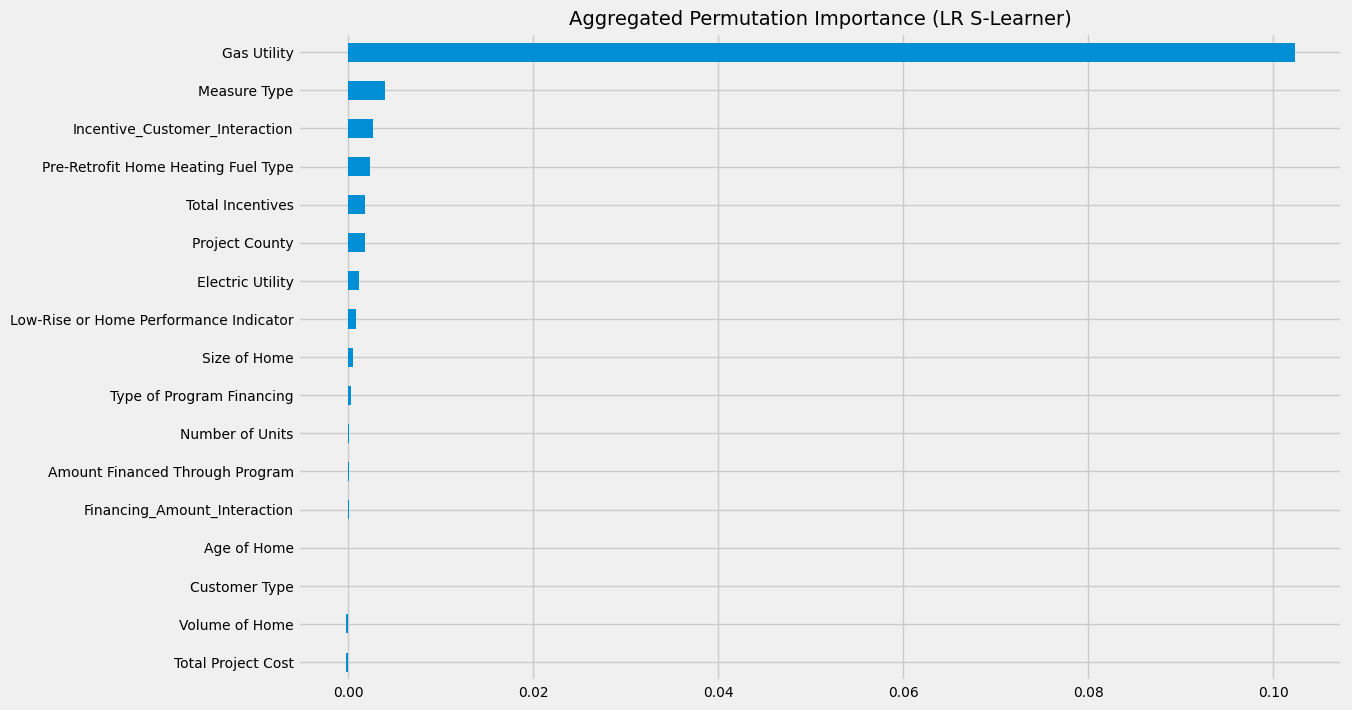

In [55]:
# Permutation importance for LR.
X_train_lr, X_test_lr, tau_train_lr, tau_test_lr = train_test_split(X_causal, tau_lr, test_size=0.3, random_state=42)
model_tau_lr = lr_model.fit(X_train_lr, tau_train_lr)
perm_lr = permutation_importance(
    estimator=model_tau_lr,
    X=X_test_lr,
    y=tau_test_lr,
    random_state=42
)
fi_lr_perm = pd.Series(perm_lr.importances_mean, index=transformed_feature_names.tolist()).sort_values(ascending=False)
print("\nPermutation Importance (LR S-Learner):")
print(fi_lr_perm)


# Aggregate permutation importance.
aggregated_perm_lr = {}
for feature, imp in fi_lr_perm.items():
    original_var = get_original_var(feature)
    aggregated_perm_lr[original_var] = aggregated_perm_lr.get(original_var, 0) + imp
aggregated_perm_lr_series = pd.Series(aggregated_perm_lr).sort_values(ascending=True)
print("\nAggregated Permutation Importance (LR):")
print(aggregated_perm_lr_series)
aggregated_perm_lr_series.plot(kind='barh', figsize=(12,8), title='Aggregated Permutation Importance (LR S-Learner)')
plt.show()


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

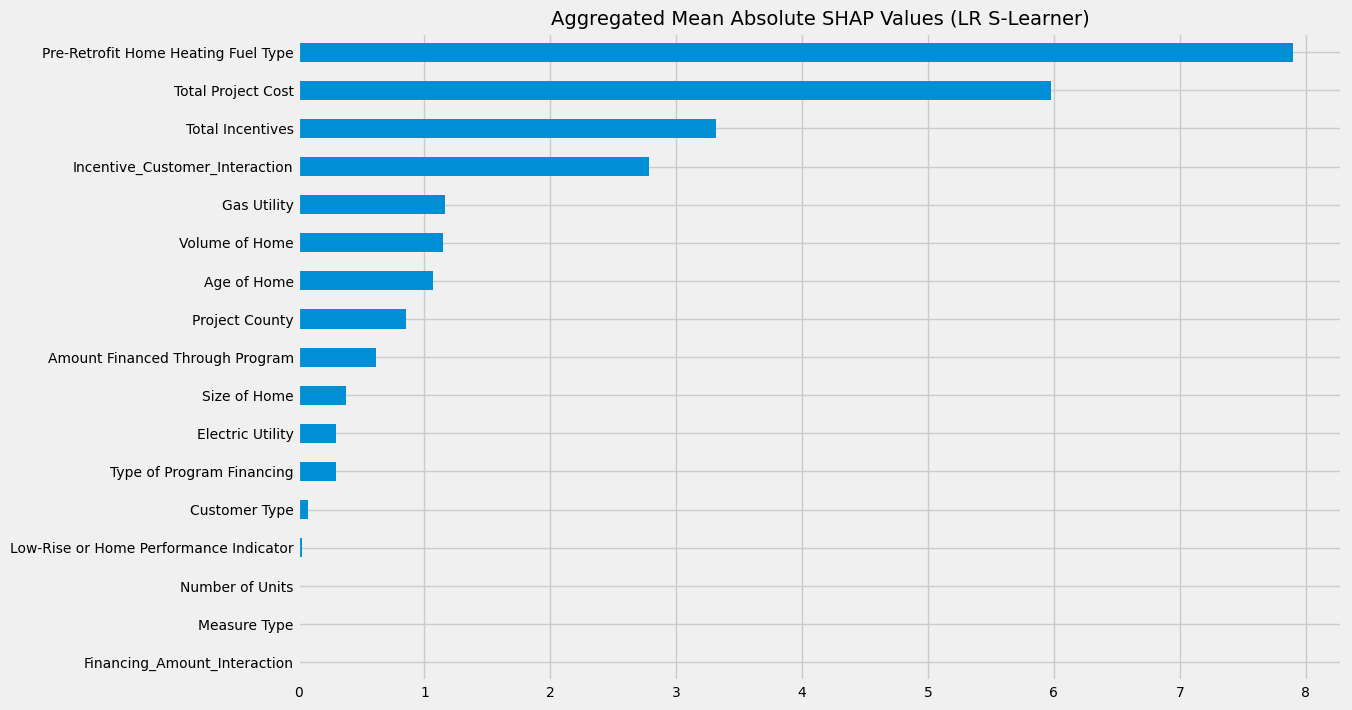

In [56]:
# Compute SHAP values for the treatment group.
# Typically, s_learner.get_shap_values returns a dictionary with key 'treatment'
shap_values = s_learner_lr.get_shap_values(X=X_causal, tau=s_learner_tau)
# Calculate the mean absolute SHAP values across samples for each transformed feature.
mean_abs_shap = np.mean(np.abs(shap_values['treatment']), axis=0)

# Create a Series mapping each transformed feature name to its mean absolute SHAP value.
shap_series = pd.Series(mean_abs_shap, index=transformed_feature_names.tolist())
print("Mean absolute SHAP values per transformed feature:")
print(shap_series)

# Now, aggregate these SHAP values by the original variable.
def get_original_var(feature_name):
    if feature_name.startswith("cat__"):
        # Remove the "cat__" prefix and then split at the first underscore.
        return feature_name[len("cat__"):].split("_")[0]
    else:
        # For numeric features, just remove the "num__" prefix.
        return feature_name.replace("num__", "")

aggregated_shap = {}
for feature, value in shap_series.items():
    original_var = get_original_var(feature)
    aggregated_shap[original_var] = aggregated_shap.get(original_var, 0) + value

aggregated_shap_series = pd.Series(aggregated_shap).sort_values(ascending=True)
print("\nAggregated Mean Absolute SHAP Values:")
print(aggregated_shap_series)

aggregated_shap_series.plot(kind='barh', figsize=(12,8), title='Aggregated Mean Absolute SHAP Values (LR S-Learner)')
plt.show()

## Experiment 3: S-Learner with XGBoost

ATE estimate (S-Learner with XGBoost): [-50.14417785]
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped trainin

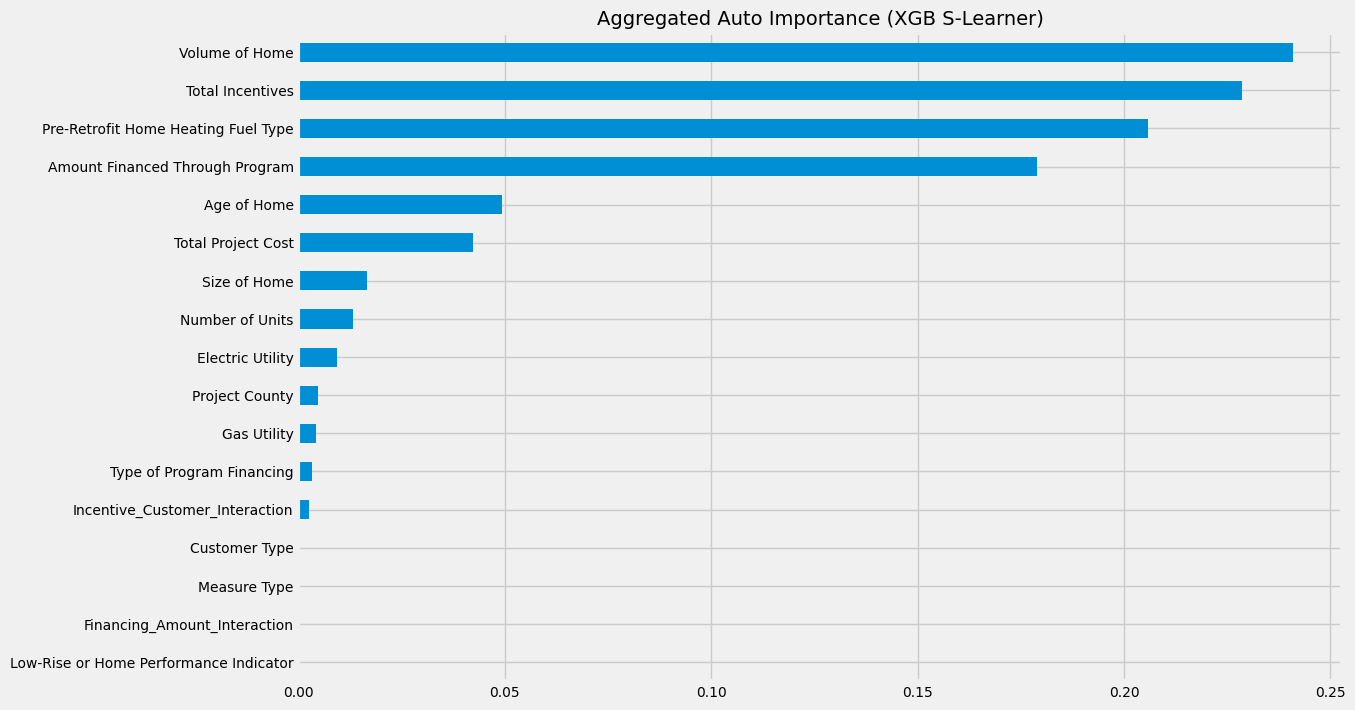

In [57]:
# Initialize the XGBoost model.
xgb_model = XGBRegressor(use_label_encoder=False, eval_metric='rmse', random_state=42)

# Create the S-Learner using the XGBoost model.
s_learner_xgb = BaseSRegressor(xgb_model, control_name='control')

# Estimate ATE.
ate_xgb = s_learner_xgb.estimate_ate(X=X_causal, treatment=w_causal, y=y_causal)
print("ATE estimate (S-Learner with XGBoost):", ate_xgb)

# Fit and predict individual treatment effects.
tau_xgb = s_learner_xgb.fit_predict(X=X_causal, treatment=w_causal, y=y_causal)

# Get auto importance.
fi_xgb_auto = s_learner_xgb.get_importance(
    X=X_causal,
    tau=tau_xgb,
    normalize=True,
    method='auto',
    features=transformed_feature_names.tolist()
)
print("\nS-Learner Auto Importance (XGBoost):")
print(fi_xgb_auto)

# Extract auto importance series.
fi_xgb_auto_series = fi_xgb_auto['treatment']

# Aggregate auto importance.
aggregated_auto_xgb = {}
for feature, imp in fi_xgb_auto_series.items():
    original_var = get_original_var(feature)
    aggregated_auto_xgb[original_var] = aggregated_auto_xgb.get(original_var, 0) + imp
aggregated_auto_xgb_series = pd.Series(aggregated_auto_xgb).sort_values(ascending=True)
print("\nAggregated Auto Importance (XGBoost):")
print(aggregated_auto_xgb_series)
aggregated_auto_xgb_series.plot(kind='barh', figsize=(12,8), title='Aggregated Auto Importance (XGB S-Learner)')
plt.show()



Permutation Importance (XGBoost S-Learner):
cat__Project County_Tompkins                                                 -4.958753e-04
cat__Electric Utility_New York State Electric & Gas                          -8.385274e-05
cat__Gas Utility_Saint Lawrence Gas                                          -1.245100e-05
cat__Gas Utility_Orange & Rockland                                           -2.690000e-06
cat__Gas Utility_Corning Natural Gas                                         -2.250085e-07
cat__Type of Program Financing_ESTAR                                         -9.085989e-08
cat__Gas Utility_Long Island Power Authority                                  0.000000e+00
cat__Pre-Retrofit Home Heating Fuel Type_Bituminous Coal                      0.000000e+00
cat__Measure Type_Water Heater                                                0.000000e+00
num__Financing_Amount_Interaction                                             0.000000e+00
cat__Pre-Retrofit Home Heating Fuel Type_Anth

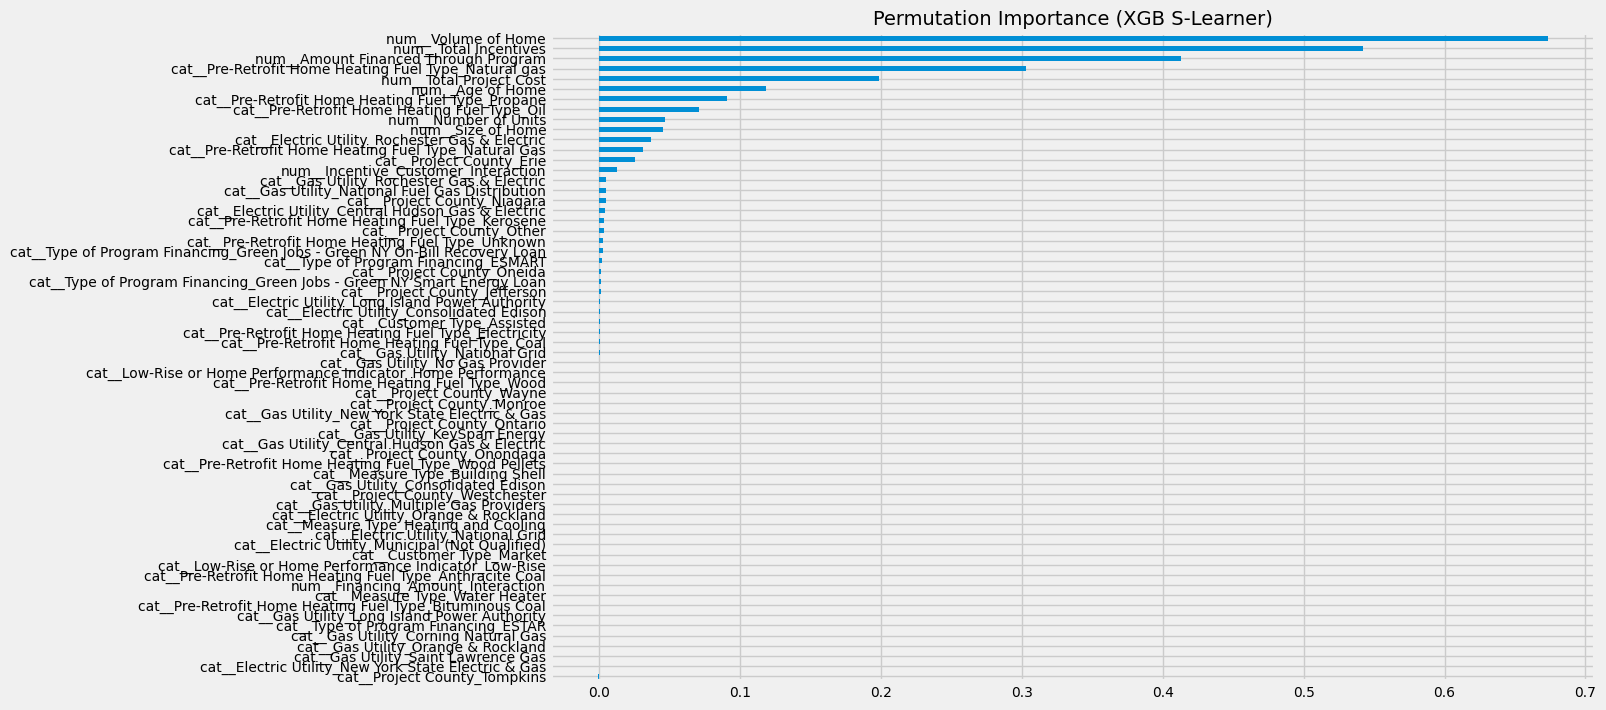


Aggregated Permutation Importance (XGBoost):
Financing_Amount_Interaction              0.000000
Measure Type                              0.000043
Low-Rise or Home Performance Indicator    0.000248
Customer Type                             0.000759
Type of Program Financing                 0.006315
Gas Utility                               0.010650
Incentive_Customer_Interaction            0.012518
Project County                            0.036621
Electric Utility                          0.042863
Size of Home                              0.045620
Number of Units                           0.046580
Age of Home                               0.118420
Total Project Cost                        0.198353
Amount Financed Through Program           0.412789
Pre-Retrofit Home Heating Fuel Type       0.503673
Total Incentives                          0.542274
Volume of Home                            0.673086
dtype: float64


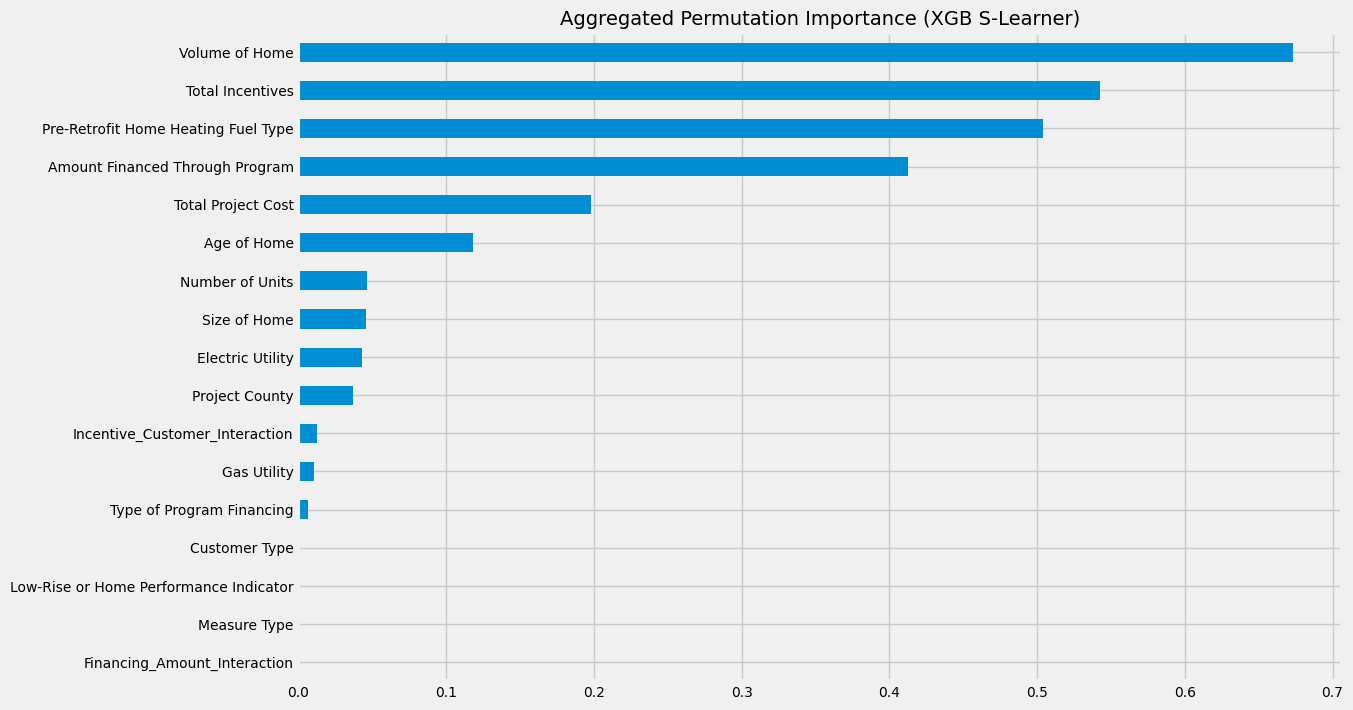

In [58]:
# Permutation importance for XGBoost.
X_train_xgb, X_test_xgb, tau_train_xgb, tau_test_xgb = train_test_split(X_causal, tau_xgb, test_size=0.3, random_state=42)
model_tau_xgb = xgb_model.fit(X_train_xgb, tau_train_xgb)
perm_xgb = permutation_importance(
    estimator=model_tau_xgb,
    X=X_test_xgb,
    y=tau_test_xgb,
    random_state=42
)
fi_xgb_perm = pd.Series(perm_xgb.importances_mean, index=transformed_feature_names.tolist()).sort_values(ascending=True)
print("\nPermutation Importance (XGBoost S-Learner):")
print(fi_xgb_perm)
fi_xgb_perm.plot(kind='barh', figsize=(12,8), title='Permutation Importance (XGB S-Learner)')
plt.show()

# Aggregate permutation importance.
aggregated_perm_xgb = {}
for feature, imp in fi_xgb_perm.items():
    original_var = get_original_var(feature)
    aggregated_perm_xgb[original_var] = aggregated_perm_xgb.get(original_var, 0) + imp
aggregated_perm_xgb_series = pd.Series(aggregated_perm_xgb).sort_values(ascending=True)
print("\nAggregated Permutation Importance (XGBoost):")
print(aggregated_perm_xgb_series)
aggregated_perm_xgb_series.plot(kind='barh', figsize=(12,8), title='Aggregated Permutation Importance (XGB S-Learner)')
plt.show()

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

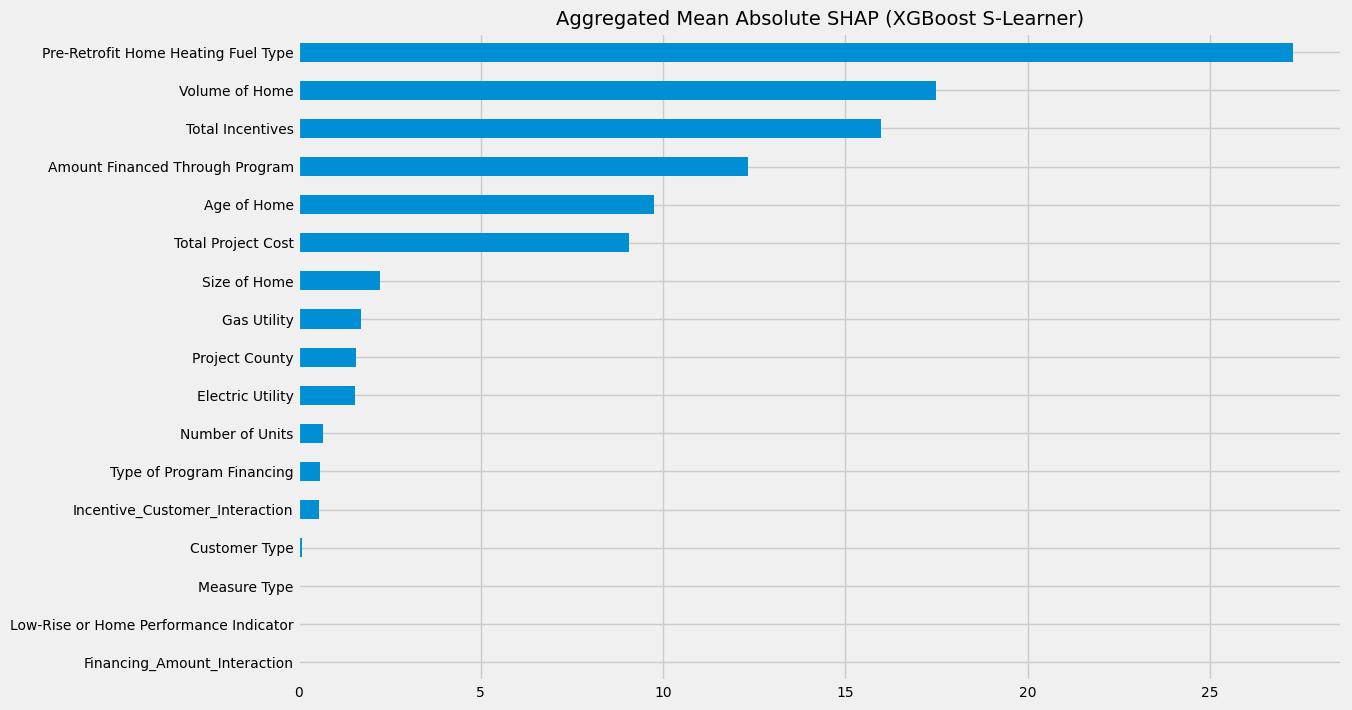

In [59]:
# Compute SHAP values using the XGBoost S-learner.
shap_values_xgb = s_learner_xgb.get_shap_values(X=X_causal, tau=tau_xgb)
# Compute mean absolute SHAP values for each transformed feature.
mean_abs_shap_xgb = np.mean(np.abs(shap_values_xgb['treatment']), axis=0)
# Create a Series using the transformed feature names.
shap_series_xgb = pd.Series(mean_abs_shap_xgb, index=transformed_feature_names.tolist())
print("Mean Absolute SHAP Values (XGBoost S-Learner):")
print(shap_series_xgb)

# Aggregate the SHAP values by original variable.
aggregated_shap_xgb = {}
for feature, value in shap_series_xgb.items():
    original_var = get_original_var(feature)
    aggregated_shap_xgb[original_var] = aggregated_shap_xgb.get(original_var, 0) + value

aggregated_shap_xgb_series = pd.Series(aggregated_shap_xgb).sort_values(ascending=True)
print("\nAggregated Mean Absolute SHAP Values (XGBoost S-Learner):")
print(aggregated_shap_xgb_series)

aggregated_shap_xgb_series.plot(kind='barh', figsize=(12,8), 
                                title='Aggregated Mean Absolute SHAP (XGBoost S-Learner)')
plt.show()

## Experiment 4: X-Learner with XGBoost

In [76]:
from causalml.propensity import ElasticNetPropensityModel

# Fit a propensity model using ElasticNet
propensity_model = ElasticNetPropensityModel()
p_scores = propensity_model.fit_predict(X_causal, w_causal)

# Ensure all scores are within (0,1) by applying smoothing
eps = 1e-5  # Small value to ensure strictly positive probabilities
p_scores = np.clip(p_scores, eps, 1 - eps)

# Standardize the fuel type column (convert to lowercase and strip spaces)
X_train_added_features['Pre-Retrofit Home Heating Fuel Type'] = (
    X_train_added_features['Pre-Retrofit Home Heating Fuel Type']
    .astype(str)
    .str.strip()
    .str.lower()
)

# Ensure alignment by reindexing `X_train_added_features` using `X_train_prepared_df`
X_train_added_features = X_train_added_features.loc[X_train_prepared_df.index].reset_index(drop=True)
w_causal = w_causal.loc[X_train_prepared_df.index].reset_index(drop=True)
y_causal = y_causal.loc[X_train_prepared_df.index].reset_index(drop=True)
p_scores = pd.Series(p_scores, index=X_train_prepared_df.index).reset_index(drop=True)

# Get unique fuel types after standardization
fuel_types = X_train_added_features['Pre-Retrofit Home Heating Fuel Type'].unique()
print(f"Fuel Types in the Data (Standardized): {fuel_types}")

# Dictionary to store ATE estimates by fuel type
ate_by_fuel = {}

# Iterate over fuel types and fit separate models
for fuel in fuel_types:
    mask = X_train_added_features['Pre-Retrofit Home Heating Fuel Type'] == fuel

    # Align index properly
    X_fuel = X_causal.loc[mask.values].reset_index(drop=True)
    w_fuel = w_causal.loc[mask.values].reset_index(drop=True).values
    y_fuel = y_causal.loc[mask.values].reset_index(drop=True).values
    p_fuel = p_scores.loc[mask.values].reset_index(drop=True).values

    # Skip fuel types with very few samples
    if len(y_fuel) < 50:
        print(f"Skipping {fuel} due to insufficient data ({len(y_fuel)} samples).")
        continue

    print(f"Processing Fuel Type: {fuel} with {len(y_fuel)} samples.")

    # Initialize and fit the X-Learner
    x_learner = BaseXRegressor(learner=xgb_model, control_name=0)  # Market = control
    x_learner.fit(X=X_fuel, treatment=w_fuel, y=y_fuel, p=p_fuel)

    # Estimate ATE using valid propensity scores
    ate_fuel = x_learner.estimate_ate(X_fuel, treatment=w_fuel, y=y_fuel, p=p_fuel)
    ate_by_fuel[fuel] = ate_fuel[0]

# Convert results to DataFrame and display
ate_df = pd.DataFrame(ate_by_fuel.items(), columns=['Fuel Type', 'ATE'])

print("\nATE estimates by Pre-Retrofit Home Heating Fuel Type (Standardized):")
print(ate_df)


Fuel Types in the Data (Standardized): ['natural gas' 'oil' 'wood' 'electricity' 'propane' 'unknown'
 'wood pellets' 'kerosene' 'coal' 'bituminous coal' 'anthracite coal']
Processing Fuel Type: natural gas with 32056 samples.
Processing Fuel Type: oil with 5602 samples.
Processing Fuel Type: wood with 328 samples.
Processing Fuel Type: electricity with 870 samples.
Processing Fuel Type: propane with 2227 samples.
Processing Fuel Type: unknown with 1588 samples.
Processing Fuel Type: wood pellets with 116 samples.
Processing Fuel Type: kerosene with 102 samples.
Skipping coal due to insufficient data (26 samples).
Skipping bituminous coal due to insufficient data (6 samples).
Skipping anthracite coal due to insufficient data (4 samples).

ATE estimates by Pre-Retrofit Home Heating Fuel Type (Standardized):
      Fuel Type                    ATE
0   natural gas   [-57.99826784332806]
1           oil   [-265.2016685274559]
2          wood   [-239.8394342701589]
3   electricity   [-340.931

Note: To see heterogeneous treatment effects and to analyse if the average treatment effects are different by subgroup, showing "conditional average treatment effect" (CATE) below.

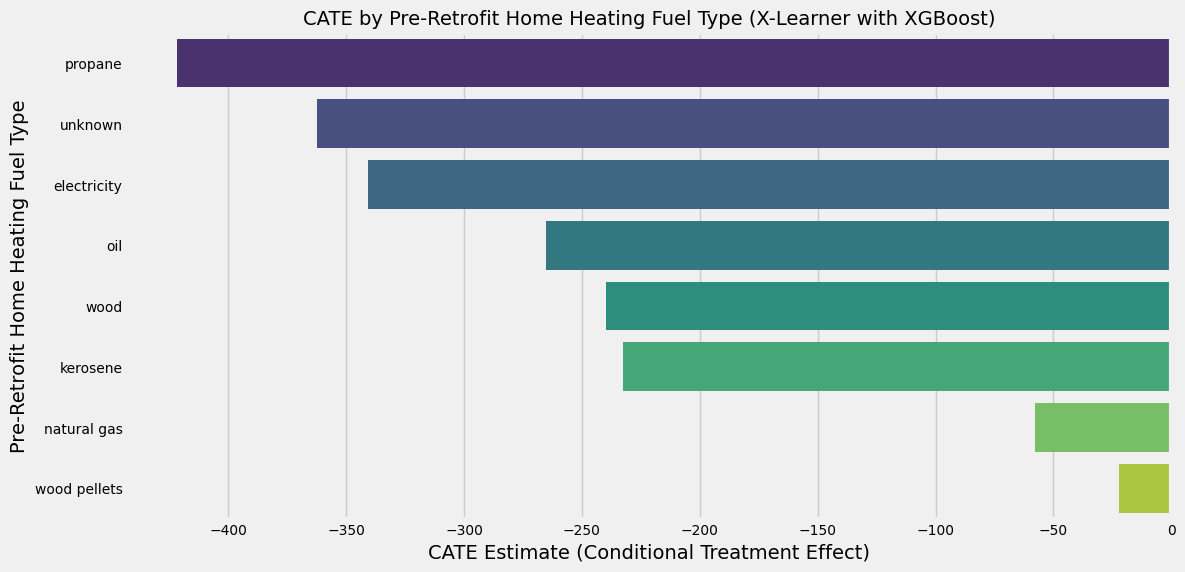

In [77]:
# Rename ATE to CATE for clearer interpretation
ate_df.rename(columns={'ATE': 'CATE'}, inplace=True)

# Convert CATE values to numeric (extract from list if necessary)
ate_df['CATE'] = ate_df['CATE'].apply(lambda x: x[0] if isinstance(x, (list, tuple, np.ndarray)) else x)

# Sort for better visualization
ate_df = ate_df.sort_values(by='CATE', ascending=True)

# Plot CATE by Fuel Type
plt.figure(figsize=(12, 6))
sns.barplot(x='CATE', y='Fuel Type', data=ate_df, palette="viridis")

# Formatting
plt.xlabel("CATE Estimate (Conditional Treatment Effect)")
plt.ylabel("Pre-Retrofit Home Heating Fuel Type")
plt.title("CATE by Pre-Retrofit Home Heating Fuel Type (X-Learner with XGBoost)")

# Show plot
plt.show()

## Causal ML Analysis: Assisted vs. Market Treatment Effects

---
### Key Findings

#### Feature Importance Analysis (S-Learner and X-Learner)
- Across models, 'Pre-Retrofit Home Heating Fuel Type' consistently appeared as the most important feature, indicating that fuel switch (from which fuel type to which fuel type) has strong influence on energy savings.
- 'Total Incentives', 'Total Project Cost', Volume of Home' also had strong influences, confirming that financial factors play a key role in energy savings.
- 'Other contributing factors' included Age of Home, Volume of Home, and Gas Utility type.
- By considering 'Pre-Retrofit Home Heating Fuel Type', it identified significant variation in incentive effectiveness, providing actionable insights for program optimization. 

#### Treatment Effect Heterogeneity by Fuel Type (X-Learner with XGBoost)

| Fuel Type       | ATE Estimate |
|-----------------|--------------|
| Natural Gas     | -57.99       |
| Oil             | -265.20      |
| Wood            | -239.83      |
| Electricity     | -340.93      |
| Propane         | -421.74      |
| Unknown         | -362.20      |
| Wood Pellets    | -22.13       |
| Kerosene        | -232.36      |

- The effect of assisted incentives varies widely by fuel type.
- Homes using 'Propane' and 'Electricity' saw the largest reductions.
- 'Wood Pellet' and 'Natural Gas' had smaller treatment effects - likely because it is already less energy intensive.
- Understanding this heterogeneity could be key to optimizing incentive structures.

#### Evaluating the Role of Financial Assistance
- The negative ATE values suggest that assisted incentives lead to higher energy savings compared to market incentives.
- Treatment effects for Assisted customers are larger than for Market customers across all fuel types.

---
### 2. Implications for Policy and Program Design

#### Optimizing Incentive Allocation
- The heterogeneity in treatment effects suggests that program organizers could adjust subsidy levels based on heating fuel type to maximize energy savings.
- 'Wood Pellet' and 'Natural Gas' customers see the lowest treatment effects, suggesting incentives should focus on more expensive fuel types.
- Higher incentives might be more justified for homes using Electricity and Propane, where the estimated treatment effects are stronger.

---



## DoWhy - effect  modifier: 'Pre-Retrofit Home Heating Fuel Type'

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import dowhy
from dowhy import CausalModel
from dowhy.datasets import linear_dataset

# Ensure the causal dataset structure is consistent
X_causal = X_train_prepared_df.copy()

# Define Treatment (Total Incentives) and Outcome (First Year Energy Savings)
treatment = "Total Incentives"
outcome = "First Year Energy Savings $ Estimate"

# Assign treatment and outcome variables
w_causal = X_train_added_features[treatment].values  # Now using Total Incentives as treatment
y_causal = y_train.values  # Outcome remains First Year Energy Savings

# Create a new DataFrame for DoWhy
df_causal = X_train_added_features.copy()
df_causal[treatment] = w_causal  # Ensure treatment is properly assigned
df_causal[outcome] = y_causal  # Ensure outcome is included

# Define Common Causes and Effect Modifiers
common_causes = [
    'Size of Home', 'Age of Home', 'Volume of Home', 'Project County', 
    'Electric Utility', 'Gas Utility', 'Type of Program Financing', 'Measure Type'
]
effect_modifiers = ['Pre-Retrofit Home Heating Fuel Type']  # Fuel type as a moderator

# Handle missing values to prevent estimation issues
df_causal = df_causal.replace([np.inf, -np.inf], np.nan).dropna()


### view_model() – Visualizing the Causal Graph

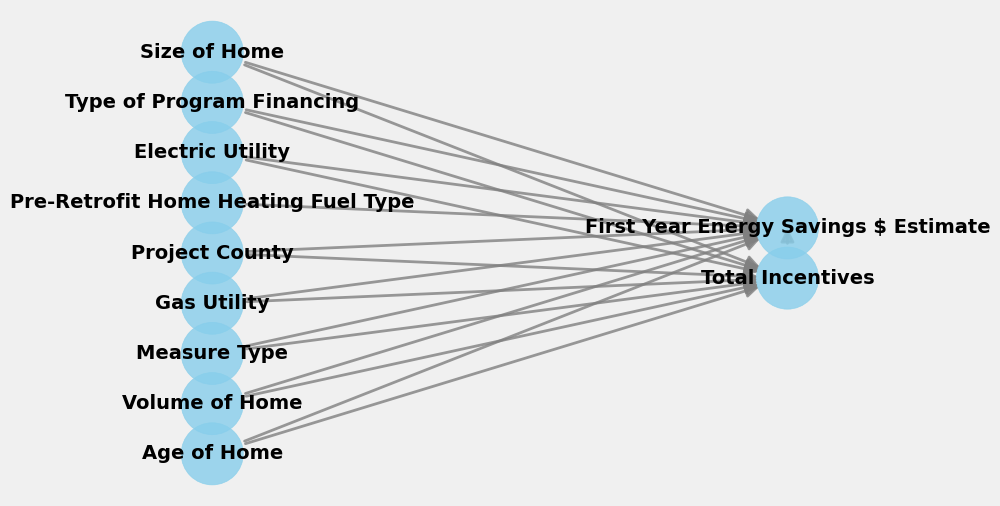

In [79]:

# Create the Causal Model
model = CausalModel(
    data=df_causal,
    treatment=treatment,
    outcome=outcome,
    common_causes=common_causes,
    effect_modifiers=effect_modifiers
)

# View the Causal Graph
model.view_model()
plt.show()


### identify_effect() – Identifying the Causal Effect

In [80]:
# Identify the Causal Effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print("Identified Estimand:", identified_estimand)


Identified Estimand: Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                                                     ↪
───────────────────(E[First Year Energy Savings $ Estimate|Age of Home,Volume  ↪
d[Total Incentives]                                                            ↪

↪                                                                              ↪
↪ of Home,Measure Type,Gas Utility,Project County,Electric Utility,Type of Pro ↪
↪                                                                              ↪

↪                              
↪ gram Financing,Size of Home])
↪                              
Estimand assumption 1, Unconfoundedness: If U→{Total Incentives} and U→First Year Energy Savings $ Estimate then P(First Year Energy Savings $ Estimate|Total Incentives,Age of Home,Volume of Home,Measure Type,Gas Utility,Project County,Electric Utility,Type of Program Financing,Size of

### estimate_effect() – Estimating the Causal Effect

In [81]:

# Estimate the Causal Effect using Linear Regression
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression",
    target_units="ate"
)
print("Causal Effect Estimate:", estimate)


Causal Effect Estimate: *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                                                     ↪
───────────────────(E[First Year Energy Savings $ Estimate|Age of Home,Volume  ↪
d[Total Incentives]                                                            ↪

↪                                                                              ↪
↪ of Home,Measure Type,Gas Utility,Project County,Electric Utility,Type of Pro ↪
↪                                                                              ↪

↪                              
↪ gram Financing,Size of Home])
↪                              
Estimand assumption 1, Unconfoundedness: If U→{Total Incentives} and U→First Year Energy Savings $ Estimate then P(First Year Energy Savings $ Estimate|Total Incentives,Age of Home,Volume of Home,Measure Type,Gas Utility,Project County

In [82]:
# Perform Refutation Tests
refute_test = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter")
print("Refutation Test - Placebo Treatment:\n", refute_test)

refute_subset = model.refute_estimate(identified_estimand, estimate, method_name="data_subset_refuter")
print("Refutation Test - Data Subset Refuter:\n", refute_subset)

Refutation Test - Placebo Treatment:
 Refute: Use a Placebo Treatment
Estimated effect:0.020329167687862082
New effect:0.00040029365009161213
p value:0.8400000000000001

Refutation Test - Data Subset Refuter:
 Refute: Use a subset of data
Estimated effect:0.020329167687862082
New effect:0.020611418284357797
p value:1.0



## DoWhy - effect  modifier: 'Age of Home' and 'Volume of Home'

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import dowhy
from dowhy import CausalModel
from dowhy.datasets import linear_dataset

# Ensure the causal dataset structure is consistent
X_causal = X_train_prepared_df.copy()

# Define Treatment (Total Incentives) and Outcome (First Year Energy Savings)
treatment = "Total Incentives"
outcome = "First Year Energy Savings $ Estimate"

# Assign treatment and outcome variables
w_causal = X_train_added_features[treatment].values  # Now using Total Incentives as treatment
y_causal = y_train.values  # Outcome remains First Year Energy Savings

# Create a new DataFrame for DoWhy
df_causal = X_train_added_features.copy()
df_causal[treatment] = w_causal  # Ensure treatment is properly assigned
df_causal[outcome] = y_causal  # Ensure outcome is included

# Define Common Causes and Effect Modifiers
common_causes = [
    'Size of Home', 'Project County', 'Electric Utility', 
    'Gas Utility', 'Type of Program Financing', 'Measure Type'
]
effect_modifiers = ['Age of Home', 'Volume of Home']  # Keeping them separate

# Handle missing values to prevent estimation issues
df_causal = df_causal.replace([np.inf, -np.inf], np.nan).dropna()


In [87]:

# Identify the Causal Effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print("Identified Estimand:", identified_estimand)


Identified Estimand: Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                                                     ↪
───────────────────(E[First Year Energy Savings $ Estimate|Measure Type,Gas Ut ↪
d[Total Incentives]                                                            ↪

↪                                                                              ↪
↪ ility,Project County,Electric Utility,Type of Program Financing,Size of Home ↪
↪                                                                              ↪

↪   
↪ ])
↪   
Estimand assumption 1, Unconfoundedness: If U→{Total Incentives} and U→First Year Energy Savings $ Estimate then P(First Year Energy Savings $ Estimate|Total Incentives,Measure Type,Gas Utility,Project County,Electric Utility,Type of Program Financing,Size of Home,U) = P(First Year Energy Savings $ Estimate|Total Incentives,Measure Type,Gas Utility,Project County,E

In [88]:

# Estimate the Causal Effect using Linear Regression
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression",
    target_units="ate"
)
print("Causal Effect Estimate:", estimate)


Causal Effect Estimate: *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                                                     ↪
───────────────────(E[First Year Energy Savings $ Estimate|Measure Type,Gas Ut ↪
d[Total Incentives]                                                            ↪

↪                                                                              ↪
↪ ility,Project County,Electric Utility,Type of Program Financing,Size of Home ↪
↪                                                                              ↪

↪   
↪ ])
↪   
Estimand assumption 1, Unconfoundedness: If U→{Total Incentives} and U→First Year Energy Savings $ Estimate then P(First Year Energy Savings $ Estimate|Total Incentives,Measure Type,Gas Utility,Project County,Electric Utility,Type of Program Financing,Size of Home,U) = P(First Year Energy Savings $ Estimate|Total I

In [89]:

# Perform Refutation Tests
refute_test = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter")
print("Refutation Test - Placebo Treatment:\n", refute_test)


Refutation Test - Placebo Treatment:
 Refute: Use a Placebo Treatment
Estimated effect:0.017662877114617004
New effect:0.00013024105744250392
p value:0.98



In [90]:

refute_subset = model.refute_estimate(identified_estimand, estimate, method_name="data_subset_refuter")
print("Refutation Test - Data Subset Refuter:\n", refute_subset)


Refutation Test - Data Subset Refuter:
 Refute: Use a subset of data
Estimated effect:0.017662877114617004
New effect:0.017642647643899067
p value:0.9199999999999999



## Conclusion from DoWhy: 'Pre-Retrofit Home Heating Fuel Type'

### Causal Effect Estimation
- The Average Treatment Effect (ATE) was 0.0203, meaning that for every additional dollar in incentives, the expected energy savings increased by 2.03 cents on average.
- However, treatment effects varied significantly by fuel type:
  - Kerosene saw the largest effect (2.46), suggesting high energy savings when incentives were applied.
  - Oil and Propane also had strong positive effects.
  - Natural Gas had the lowest effect (0.0061), indicating that additional incentives may not significantly boost energy savings for homes using this fuel.

## Conclusion from DoWhy: 'Age of Home' and 'Volume of Home'

### Causal Effect Estimation
  - Older homes (108+ years) with smaller volumes (≤10,241 sq ft) had the largest effect (0.048), meaning incentives were most effective in these homes.
  - Larger homes (>19,576 sq ft) consistently showed lower or negative effects, suggesting that incentives might not drive as much energy savings in very large homes.
  - Homes aged 55-83 years also showed moderate treatment effects, reinforcing that mid-to-older homes respond better to incentives than newer homes.

### Refutation Tests

- For both analysis, Placebo Treatment Test suggested the original effect was not driven by random noise. Data Subset Refuter confirmed that the estimate is robust to missing data.